First principles of "doing stuff" are things like graph and numeric operations, and search and optimizers.

So let's… do those.

We'll use Python, of course, the slowest gun in the West.    
This is in a Jupyter notebook.    
It's funny and educational.    
Maybe leave.    
Maybe read through.    
Maybe clone and play with code.    
Maybe clone and erase some code and implement for full mastery.    
Have fun doing what you want to do.

```bash
sudo apt install python3 python3-pip
pip3 install jupyter
```

## Examples

First, the interfaces that we'd like to use, for inspiration.    
No need to understand them all completely for now. Understanding goes with implementation, which is below all these.

(Cannot run them, only look.)

Search for hyperparameters:

```python
@state(a=real(0,1), b=one('x', 'y', 'z'), c=one('x', 'y', 'z'))
@examples((0.2, 'x'), (0.8, 'z'))
def probability_to_char(st, x):
    return st.b if x < st.a else st.c

print(probability_to_char(0.9)) # 'z'
```

Search for a linear decision tree:

```python
@state(
    result = label('num'),
    num = one(
        0,
        1,
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x+y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x-y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x*y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x/y),
        compose(label('num'), label('num'), label('num'), label('num'), out=label('num')(lambda x,a,b,c: b if x<a else c)),
    )
)
def hidden_learned_numeric_function(st, x: label('num'), y: label('num')):
    return st.result
# Can also be written as:
# hidden_learned_numeric_function = state( result=… )('result')


@examples((1, 10), (2, 15), (3, 16), (4, 5234), (10, 10000))
def learned_function(x):
    return hidden_learned_numeric_function(x, x*x) + 10

print(learned_function(7))

state.pprint(state._get_impl(learned_function))
```

```python
# Pattern-matching on an input.
import math
@state(
    result = label('num'),
    num = one(
        0,
        1,
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x+y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x*y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x/y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: math.pow(x,y)),
    )
)
def hidden_learned_numeric_function2(st, f: one('x', 'y', one.object_id), x: label('num')):
    return st.result


@examples((1, 2), (2, 4), (3, 8))
def learned_function1(x):
    return hidden_learned_numeric_function2('x', x)

@examples((1, 2), (2, 4), (3, 6))
def learned_function2(x):
    return hidden_learned_numeric_function2('y', x)

@examples((1, 10), (2, 11), (3, 12))
def learned_function3(x):
    return hidden_learned_numeric_function2(learned_function3, x)

print(learned_function1(4), learned_function2(4), learned_function3(4))
```

Persistence:

```python
@state(
    'learned123213',
    a = real(0,1)
)
def met(st):
    return st.a
for i in range(100):
    examples.add(met, out = 0.5 + i/200)

state.load('saveToAndLoadFrom.bin', autosave = False)
examples.fit(examples.new, examples.timeout(5000))
examples.fit(examples.all, examples.timeout(500))
state.save()
```

State inlining (multiple callsites of the same function in another function get treated as one) (analogous to transfer learning):

```python
@state(a=one(1,2))
@examples(1)
def function1(st):
    return st.a

@state(a=2)
@examples(4)
def function4(st):
    return function1() + st.a

print(function1(), function4()) # 1, 4

state.pprint(state._get_impl(function1).a) # history(one(1,2), 1)

# Accomplished via automatically randomly calling:
# state.inline(function4, function1)
#   Also pass in inline = True or False or state.apply_copy or max inlining depth (default is 1)
#     (or a function that accepts caller and callee, returning one of those four)
#     to specify other de/inlining behavior.
#   Pass in None instead of function1 to de/inline all called functions' states.
#   Pass in None instead of function4 to specify global behavior.
```

Max/min-imization:

```python
@state(a = real(-1,1), b = real(-1,1), c = real(-1,1))
@examples(*( (x*10, float('-inf')) for x in range(-10, 10) ))
def minimize_at_points(st, x):
    a = st.a * st.a
    b = (st.b + 0.1) * (st.b - 0.5)
    c = abs(st.c * x)
    return a + b + c + x

import matplotlib.pyplot as plt
plt.plot([minimize_at_points(x) for x in range(-100, 100)])
plt.ylabel('minimize_at_points')
plt.show()
```

Internals: `compose.context`/`.in`/`.out` (used for search) and arbitrary types.

```python
# There is no one best search method and details,
#   so these 'internals' make search simple enough to hopefully be customized easily.
with compose.context(num = 1):
    with compose.context(num = 2):
        with compose.context(num = 3):
            print(compose.out(label('num'))) # one(1, 2, 3)

with compose.context(1, 3, 5, 7, 9, num = real(0,10)):
    x = one(1, 2, label('num'))
    print(compose.ins(x)) # one._pattern_match(1, 2, 'num')
    print(compose.out(x)) # (1, 2, real(0, 10))
    y = compose.type((1, 2, 3), None) # (enum)
    print(compose.ins(y)) # (1, 2, 3)
    print(compose.out(y)) # None — no further composition needed, usable as-is if found.
    z = compose.type(None, lambda x: x if isinstance(x, int) and x <= 5 else None) # (filter)
    print(compose.ins(z)) # None
    print(compose.out(z)) # (1, 3, 5)
    w = compose.type(None, lambda x: x)
    print(compose.ins(w)) # None
    print(compose.out(w)) # (1, 3, 5, 7, 9, real(0, 10))



# Internals: picking from options.
import random
def random_index(*a):
    L = len(a)
    return random.int(0, L-1) if L > 0 else None
with compose.picker(lambda a: random_index(x for x in a if x>=5)):
    with compose.context(1, 5, 10):
        top = compose.type(None, lambda x: x)
        print(compose.pick(top)) # 5 or 10
        print((x for x in compose.picks(top))) # 5,10 or 10,5



# Internals: undo-enabled transformations.
undo_example_default_a = history(real(0,10), one(1,2,3), 2)
undo_example = state(
    a = undo_example_default_a
)('a')

state._set_impl(undo_example, 'a', undo_example_default_a)

# The appropriate value will be found much faster than with just a=real(0,10).
examples.add(undo_example, out = 3)
examples.fit(undo_example, examples.timeout(100))
print(undo_example()) # 3
# In operations that our library implements, for each type of set,
#   we'd like to have set=>subset functions that rely on history to speed up minor changes.
```

Search optimization (optimize how fast things are optimized):

```python
for i in range(10):
    start_time = examples.time()
    def search_speed(f, got, expected):
        return examples._loss(f) * start_time()
    with compose.context(metrics = search_speed):
        examples.fit(examples.all, examples.timeout(1000))



# Memory limiting and optimization.
@state(
    result = one('x', compose(lambda x: x+1, 'x', 'x'))
)
def mem_limiting_example(st, x: 'x'):
    return st.result
state.byte_limit(mem_limiting_example, 100) # Limit the sum of sys.getsizeof()


def memory(since = 0):
    # Somewhat accurate to kilobytes.
    import resource
    u = resource.getrusage(resource.RUSAGE_SELF)
    mem = u.ru_ixrss + u.ru_idrss + u.ru_isrss
    if not mem:
        mem = u.ru_maxrss
    if sys.platform != 'darwin':
        mem = mem * 1024
    return mem - since
start_memory = memory()
with compose.context(metrics = lambda f,g,e: -memory(start_memory)):
    examples.fit(examples.all, examples.timeout(5000))

# These are areas where it is practically impossible to come up with universally good metrics or optimization way,
#   so advanced metric (and search-impl) enumeration and search would be required.
```

## Why

Ah, the age-old question of "why does this exist?".

To put it simply, right now we want to make a reliable library for adding structural learning to ML's numerical learning, similar to AutoML frameworks. But our thinking that led to this is broader.

Intelligence is beyond static descriptions and beyond static numerics.    
Natural language transformer networks, using comments to select which feature is the most appropriate to implement another.    
A mental list of tasks that a person does, having spent a lifetime learning when to take on a new task, when to work on the list, when the work is good enough, and when to give up.    
Vast groups that co-learned the same meanings and implications of words, and the gradual drift of those meanings and eventually words themselves over time, in groups and individuals alike.    
People learning how to adjust the program they wrote in response to errors they see, learning appropriate dynamic contexts of static parameters (if they depend on the phase of the moon, it will be found out), and learning re-usable parts and when to learn them for most effective transfer learning.    
Only a fully dynamic thing behaves like that.

Here, we hope to try out a new stateful approach to writing software, where only the most important things are formalized, and the rest is learned.

We'd like to put lessons of machine learning (mainly "don't write down one way, write down all ways, and defer choices to the machine") into a non-numeric form.

More, we'd like an arbitrary-program optimization base that can represent and optimize fully-dynamic behavior, then develop it to be more like known intelligence, and ease the transition.

## Carcass

Our next step here is to consolidate all those examples into the library's skeleton, which includes full interfaces and comments on how each function is to be implemented.

In [15]:
# Public interface:

# state(__name = None, **vars)(func_or_varname)
#   load(filename, autosave = True)
#   save(filename = last_loaded_filename)
#   override(func_id_to_impl) -> context_manager
#   pprint(state)
#   inline(func = None, inner_func = None, inline = 1)
#   byte_limit(func, bytes)
#   _get_impl(func, varname = None)
#   _set_impl(func, varname, impl)
# examples(*args_to_out)(func)
#   add(func, *args, out)
#   fit(func, stopping_check)
#   timeout(ms) -> function finished()->bool
#   time() -> function time_since()->ms
#   new: list
#   all: list
#   _loss(func)
# compose(func, *arg_sets, out)
#   context(*values, **label_set_additions) -> context manager
#   ins(object)
#   out(object)
#   type(enum, filter)
#   picker(list_to_index_function) -> context manager
#   pick(object)
#   picks(object) -> iterator
# match(value, branches)
#   id
# label(name)
# history(*past_then_present) datatype
# many(*of) datatype
# one(*of) datatype
# real(min, max) datatype
# int(min, max) datatype

# Executing a function, with composable arbitrary backprop:
#   execute(func, ins = None) -> many(out, exec_state)
#   adjust(func, ins, out, dout, exec_state) -> dins

# _parse(bytes) -> obj
# _serialize(obj) -> bytes

import sys # getsizeof
import math # isinf
import time # clock
import random
import inspect # getsource
import weakref # finalize, WeakValueDictionary
from numbers import Number

# All datatypes have a uniform repr:
#   Struct(head, *data) which inherits from list.
_bytes = 0
class Struct(list):
    def __init__(self, *head_then_args):
        global _bytes
        super().__init__(head_then_args)
        _bytes += sys.getsizeof(self)
        # Keep track of byte-precise memory ourselves.
    def __del__(self):
        global _bytes
        _bytes -= sys.getsizeof(self)
        # Assuming that structs are immutable.




class State:
    # Using @staticmethod is too verbose.
    # Is there any other way to do non-file-based namespacing in Python?

    def __call__(_, __name = None, **kwvars):
        """Decorator for specifying state state for functions.
        A function will have an extra arg in front for getting state; do not store it."""
        ## is TBD
        def decorate(func):
            nonlocal __name
            if __name is None:
                __name = inspect.getsource(func)
            ## And set _state_names[__name] to func for save/load.
            func.states = {id(func):kwvars}
            def replacement(*args, **kwargs):
                global _current_func
                _current_func = func
                with state.override(func.states):
                    return func(_current_state_object, *args, **kwargs)
            for k,v in vars(func).items():
                setattr(replacement, k, v)
            return replacement
        return decorate
    
    def load(_, filename, autosave = True):
        """Loads global state from file."""
        ## Read file bytes.
        ## Turn file bytes into an object graph with _parse(bytes).
        ## Set functions' states named in _state_names to what they are in the graph.
        pass
    
    def save(_, filename = None):
        """Saves global state to file, the last loaded one by default."""
        ## that = {k:state._get_impl(v) for k,v in _state_names.items()}
        ## Get bytes with _serialize(that).
        ## Write them.
        pass
    
    def override(_, func_id_to_state):
        """Returns a context manager that overrides function impls, for inlining."""
        class StateSetter:
            __slots__ = ['fs']
            def __init__(self, fs):
                self.fs = fs
            def __enter__(self):
                for func_id, state in self.fs.items():
                    _states[func_id] = state
            def __exit__(self,x,y,z):
                for func_id, state in self.fs.items():
                    del _states[func_id]
        return StateSetter(func_id_to_state)
    
    ## Do we need `func` in these three; isn't it always the current func?
    def _run_impl(_, func, varname):
        """Get and execute an impl."""
        impl = state._get_impl(func, varname)
        out, exec_state = execute(impl)
        ## And store exec_state in func's current exec_state cell.
        return out
    
    def _get_impl(_, func, varname = None):
        """Get a function's impl in the current state."""
        # Lookup in the first override of func in _states.
        if id(func) in _states:
            state = _states[id(func)]
            if varname is None:
                return state
            elif varname in state:
                return state[varname]
        return None
    
    def _set_impl(_, func, varname, impl):
        """Set a function's impl in the current state."""
        if id(func) in _states:
            state = _states[id(func)]
            state[varname] = impl
    
    def pprint(_, obj):
        """Pretty-prints an object."""
        pass
    
    def inline(_, func = None, inner_func = None, inline = 1):
        """Sets the global state inlining policy."""
        pass
    
    def byte_limit(_, func, bytes):
        """Sets the maximum byte count that a function's state can take."""
        pass

state = State()



class _CurrentState:
    def __getattr__(self, attr):
        return state._run_impl(_current_func, attr)

_current_state_object = _CurrentState()

_states = {}
_current_func = None



class Examples:
    def __call__(self, *args_to_out):
        """A decorator for associating input-output examples with a function."""
        def decorate(func):
            func.examples = args_to_out
            examples.all.append(func)
            weakref.finalize(func, examples.all.remove, func)
            return func
        return decorate
    
    def _loss(_, func, exs = None):
        """Computes the loss of a function over all its examples, to be minimized."""
        if exs is None:
            exs = func.examples
        dsum = 0
        for ex in exs:
            # This slice might allocate, meaning that it should be pre-done in `examples`.
            # I don't know enough about Python internals.
            intended_ins, intended_out = ex[0:-1], ex[-1]
            out, exec_state = execute(func, intended_ins)
            if not isinstance(intended_out, Number):
                dout = 0 if intended_out == out else 1
            elif not math.isinf(intended_out):
                dout = abs(out - intended_out)
            elif intended_out > 0: # +∞
                dout = -out
            else: # -∞
                dout = out
            dsum += dout
            ## We have exec_state here,
            ##   we could use it by passing it to `adjust`,
            ##   or by returning a random one.
            ## But "when" is unclear.
            ##   We'd like to optimize that automatically, later.
        return dsum
    
    def add(_, func, *args, out):
        """Adds an example to a function's example list."""
        func.examples.append((*args, out))
    
    def fit(_, func = None, stopping_check = None):
        """Executes and adjusts a function on any of its examples.
        Returns when stopping_check returns True."""
        if stopping_check is None:
            stopping_check = examples.timeout(500)
        ## while not stopping_check():
        ##   pick random example
        ##   execute
        ##   adjust
        # (Or add up loss and sample state of several examples and adjust.)
        pass
    
    def timeout(ms):
        """Returns a function that returns True when the given milliseconds have passed."""
        end_s = time.clock() + ms/1000
        def finished():
            return time.clock() <= end_s 
        return finished
    
    def time():
        """Returns a function that returns milliseconds passed since its creation."""
        start = time.clock()
        def time_since():
            return (time.clock() - start)*1000
        return time_since
    
    new = []
    all = []

examples = Examples()



class Compose:
    def __call__(_, *arg_sets, out):
        """"""
    
    def context(_, *values, **label_set_additions): # -> context manager
        """"""
    
    def ins(_, obj):
        """"""
    
    def out(_, obj):
        """"""
    
    def type(_, enum, filter):
        """"""
    
    def picker(_, list_to_index_function): # -> context manager
        """"""
    
    def pick(_, obj):
        """"""
    
    def picks(_, obj): # -> iterator
        """"""

compose = Compose()



class Label:
    __slots__ = ('name', '__weakref__')
    def __init__(self, name):
        self.name = name
    def __hash__(self):
        return hash(self.name)
    def __eq__(self, other):
        if isinstance(other, Label):
            return self.name == other.name
        return False
    # Python 3 needs no __ne__

_label_cache = weakref.WeakValueDictionary({})

def label(name):
    """Returns an object that is guaranteed to be the same for equal values of `name`."""
    if name not in _label_cache:
        L = Label(name) # Why is putting it on the same line make it call the getter?
        _label_cache[name] = L
    return _label_cache[name]



class Match:
    def __call__(self, value, branches):
        """"""
        pass
    id = """Pattern-matches on id(object)."""

match = Match()



class History:
    """A transformed value, able to be returned to its past state."""
    def __call__(self, *past_then_present):
        return Struct(History, *past_then_present)

history = History()



class Many:
    """Basically an array.
    Multiple values at once, able to be decomposed into each with `access_many`.
    When a value of a `many(…)` set is an input, becomes decomposed into each part.
    When an output, generates each branch, then puts results into an array."""
    def __call__(self, *of):
        return Struct(Many, *of)

many = Many()

def access_many(m, index):
    return m[index]



class One:
    """Basically a choice.
    Any value from ones listed, able to be recognized with `match`.
    When a value of a `one(…)` set is an input, becomes pattern-matched.
    When an output, selects a random branch to go to (with a pattern-match)."""
    def __call__(self, *of):
        return Struct(One, *of)

one = One()



class Real:
    """Any scalar number from min to max."""
    def __call__(self, min, max):
        return Struct(Real, min, max)

real = Real()



class Int:
    """Any integer from min to max."""
    def __call__(self, min, max):
        return Struct(Int, min, max)

int = Int()



def execute(func, ins = None): # -> many(out, exec_state)
    while True:
        if isinstance(func, Struct):
            if func[0] is Real:
                func = random.uniform(func[1], func[2])
            elif func[0] is Int:
                func = random.randint(func[1], func[2])
            ## Also handle Many via actual recursion.
            elif func[0] is One:
                i = random.randint(1, len(func)-1)
                func = func[i]
            elif func[0] is History:
                func = func[-1]
        ## Also execute if an SSA.
        elif isinstance(func, Label):
            func = state._get_impl(_current_func, func.name)
        elif callable(func) and ins is not None:
            return func(*ins), None
        else:
            return func, None
def adjust(func, ins, out, dout, exec_state): # -> dins
    pass



def _parse(b):
    pass
def _serialize(obj):
    pass

Midway through, I turned my brain off and went coding and learning Python along the way, so this carcass crawls with maggots: setting and getting static state works, setting examples works (but not fitting to them), flyweight labels work. Did not touch composition nor parsing+serialization, nor specialization nor execution.

I have struggled with the Python language in a few places.    
Following a reference to its definition is burdensome enough that I need to try and mentally track as much scope as I can.    
I can't be completely sure that other code won't read the properties I'm defining.    
I'm not sure about performance of particular things.    
Namespacing is weird and causes semantic noise.    
But that doesn't mean that some super language should be made that will have no mistakes in its design, even if that possibility seems closer every year.    
Certainly, efforts toward that can be made, and each will improve the situation. That's the danger of static-goal universal optimizers: optimizers that outperform them probably exist.    
Planning is everything and plans are nothing, a world model beats expert knowledge, a language is irrelevant next to the ability to make one, and dynamic is always better than static.    
That's why I'm exploring this library of dynamic generation.

Let's excise bugs by looking at how the implemented functionality behaves:

In [16]:
@state(a=real(0,1), b=one('x', 'y', 'z'), c=one('x', 'y', 'z'))
@examples((0.2, 'x'), (0.8, 'z'))
def probability_to_char(st, x):
    return st.b if x < st.a else st.c

for _ in range(3):
    print(probability_to_char(0.2), probability_to_char(0.8))
    print(probability_to_char(0.2), probability_to_char(0.2), probability_to_char(0.2))
    print(examples._loss(probability_to_char))

z x
z z x
2
y y
x y y
2
x z
y z z
0


Loss should be `0`/`1`/`2` (count of failed examples), and everything should vary constantly, because we don't sometimes rewrite state by specializing, and pick everything dynamically.

Rewriting rules and specializing with history (and `examples.fit`) should be next, to make the first example actually work.

## History

I've been thinking about program search and realized something.

Random search or evolution are: pick a random part to put into result, or pick a random part to alter/crossover randomly.

(Neural networks could be used to estimate/learn how good a choice and a resulting graph are [[Y]](https://arxiv.org/pdf/1910.11858), but structures of search and NNs are still static, and NNs' messy vocabulary makes "learning" mean only its particular kind of change. I want another change, the real search of structure.)

But that arbitrary choice can be much more than picking a random number each time and being satisfied.

We can remember the choice and maybe change it later, or replace it with a choice from a subset, or decide what to do with an arbitrary computation, generated with all this too; then maybe remember our work somewhere, decide when to forget.

This needs state, but if we have state, we can learn it.

And so, to try to reach and push the state-of-the-art on search, the idea of this library was born.

---

Previously, I spent half a year making a programming language that is perfect, has many powerful features, and is so uniform it can be written automatically.

But I realized: every new feature is another feature away from what allows intelligent behavior.

For that, a primitive SSA is better than very convenient semantics, and a library serves better than a full language.

A mind is not given to you, and must be learned from the start: 'nothing' is indistinguishable from 'everything', but 'something' is neither.

I know a lot of people blame how primitive code entry tools are, but from what I've seen, the only and real problem is the lack of intelligence in machines: 50% more thoughts captured will never equal a mind. Until the singularity is trusted and widespread, every tool will seem stone-age.

To help that, we must learn to change without fear.    
Find the everythings that can give rise to all the somethings, implement them, and make a system to learn something simple.

## Specializing with history

For real this time.

We want to be able to specify a function, that will turn an executable value in a state (`impl`) into its special case; we'd then put `history(Old, New)` back.

We can't just say "hey, user, just write whatever you want in this spot", we have to handle all cases that we've made and connections between them.    
In other words, we need to explicitly do a DAG rewrite (directed acyclic graph — basically, where objects are created one-by-one, with immutable-at-creation-time connections).    
Say, `rewritten(impl, func)` is the graph rewrite.

What does rewriting a thing with connections mean?    
Node type (whether it's a `One` or `Real` or others) is important.    
Rewrite connections (without repeating work), then rewrite the thing. There might not be connections, which we'll have to check for.    
Maybe we don't rewrite a particular node, but still want to build up some estimate for decision-making, so we need an input and an output for that.    
Which means that inputs of a rewriting function are (informally) `(estimate | None, node)`, where it's a good idea to match the first item in `node` by object id; and outputs are `many(estimate, node_becomes | None)`.    
`node_becomes` here is made by decomposing `node`, and later we'll have to specify a complete basic set of rewrites. That decomposition won't have access to new nodes, so we'll have to update `node_becomes` manually in `rewritten`.

Where would we use this function? We could try doing it with a 10% chance in `execute`, or make `adjust` walk the DAG and rewrite an impl with a 1% chance.    
Inability to find a good place for structural change may be discouraging, but that's what "we'll come back to dynamically optimize the search itself later" is for.

Enough talk, let's program it.

In [17]:
def rewritten(impl, func):
    # Walk the graph, apply `func(recursive_estimate, *node)` to each node.
    def walk(node, func, env):
        """Fills a dictionary with graph nodes' rewriting results and recursive estimates.
        `node` is a list with the node type being the first item and graph edges following, or anything else.
        `func` is like `compose('estimate', node, out=many('estimate', 'node_becomes'))`, decomposing nodes up to depth of 1.
        `env` is a dict from id(node) to the node's recursive estimate and node_becomes."""

        # The graph-walk header:
        if id(node) in env:
            return env[id(node)][0]
        env[id(node)] = None # Unneeded if there are no cycles, but good to remember.

        # Get and sum estimates of children, then pass that to `estimate`.
        ## (Any other order-independent number op can be used: mult, mean, min/max.)
        # Every one of our datatypes is a Struct, so getting connections is very simple.
        s = None
        is_struct = isinstance(node, Struct) and len(node) >= 1
        post = Struct(*node) if is_struct else node
        any_change = False
        if is_struct:
            for i in range(1, len(node)):
                child_est = walk(node[i], func, env)
                post[i] = env[id(node[i])][1]
                if post[i] is not node[i]: any_change = True
                if child_est is not None:
                    s = child_est if s is None else s + child_est

        # Collect post-rewrite dependencies in `post`.
        s, becomes = func(s, post)

        # Remember the rewrite.
        if becomes is None:
            becomes = post if any_change else node
        env[id(node)] = (s, becomes)
        return s
    env = {}
    walk(impl, func, env)
    return env[id(impl)][1]

This isn't a complete implementation of rewriting, there should also be its adjusting part to balance out the execution part we've just made: remember `env`, then post-order traversal of execution becomes pre-order traversal of adjustment.

With this, what `adjust` should be and do becomes more clear: the `@attr(adjust = adjust_override)` decorator for easily specifying its overrides, and `adjust` itself should propagate in a breadth-first manner, and handle visiting-same-node-many-times (where adjustments should be summed).

We won't do that for now, because we have a bigger problem: lacking a representation for computations. This problem may or may not make us rewrite rewriting.

Example usage of `rewritten`, to excise bugs:

In [18]:
def real_rewrites(_, a, b):
    from numbers import Number
    if isinstance(a, Number) and isinstance(b, Number):
        if a + 4 < b:
            return real(a+2, b-2)
        if a + 2 < b:
            return real(a+1, b-1)
    return a if random.randint(0,1) == 0 else b

def r(_, node):
    if isinstance(node, Struct) and node[0] is Real:
        if random.randint(0,1) == 0: # 50%
            return 0, real_rewrites(*node)
    return 0, None

[rewritten(one(real(1,3), real(real(0,1),4), real(1,5), real(1,6), 15), r) for _ in range(5)]

[[__main__.One,
  [__main__.Real, 1, 3],
  [__main__.Real, [__main__.Real, 0, 1], 4],
  [__main__.Real, 2, 4],
  [__main__.Real, 3, 4],
  15],
 [__main__.One, 1, 4, [__main__.Real, 2, 4], [__main__.Real, 1, 6], 15],
 [__main__.One,
  1,
  [__main__.Real, 0, 1],
  [__main__.Real, 1, 5],
  [__main__.Real, 3, 4],
  15],
 [__main__.One,
  3,
  [__main__.Real, 1, 4],
  [__main__.Real, 2, 4],
  [__main__.Real, 1, 6],
  15],
 [__main__.One,
  3,
  [__main__.Real, 1, 4],
  [__main__.Real, 2, 4],
  [__main__.Real, 1, 6],
  15]]

Okay, for *real* real this time, specialization with history, also known as fearless rewriting:

In [19]:
from numbers import Number

def real_specialize(_, a, b):
    if isinstance(a, Number) and isinstance(b, Number):
        return random.uniform(a, b)

def one_specialize(_, *opt):
    return random.choice(opt)

def history_generalize(_, past, present):
    return past

def specialize_y(_, node):
    becomes = None
    if isinstance(node, Struct) and random.randint(0,1) == 0: # 50%
        if node[0] is Real:
            becomes = real_specialize(*node)
        if node[0] is One:
            becomes = one_specialize(*node)
        if node[0] is History and len(node) == 3:
            becomes = history_generalize(*node)
    if becomes is not None:
        becomes = history(node, becomes)
    return 0, becomes

def to_initial(_, node):
    if isinstance(node, Struct) and node[0] is History:
        # Gotta get back, back to the past
        return 0, history_generalize(*node)
    return 0, None

def test():
    initial = one(real(1,3), real(real(0,1),4), real(1,5), real(1,6), 15)
    post1 = rewritten(initial, specialize_y)
    post2 = rewritten(post1, specialize_y)
    # The specialize-y function can be chained infinitely,
    #   and won't get stuck due to not perfectly-cyclic rewriting rules.
    back = rewritten(post2, to_initial)
    return ['1:', post1, '2:', post2, 'back:', back]
test()

['1:',
 [__main__.One,
  [__main__.Real, 1, 3],
  [__main__.Real, [__main__.Real, 0, 1], 4],
  [__main__.Real, 1, 5],
  [__main__.History, [__main__.Real, 1, 6], 5.407856098973323],
  15],
 '2:',
 [__main__.History,
  [__main__.One,
   [__main__.History, [__main__.Real, 1, 3], 1.2664426274683964],
   [__main__.Real,
    [__main__.History, [__main__.Real, 0, 1], 0.6151187219172428],
    4],
   [__main__.History, [__main__.Real, 1, 5], 3.755001579619755],
   [__main__.History,
    [__main__.History,
     [__main__.History, [__main__.Real, 1, 6], 3.8132556246094502],
     5.407856098973323],
    [__main__.History, [__main__.Real, 1, 6], 3.8132556246094502]],
   15],
  15],
 'back:',
 [__main__.One,
  [__main__.Real, 1, 3],
  [__main__.Real, [__main__.Real, 0, 1], 4],
  [__main__.Real, 1, 5],
  [__main__.Real, 1, 6],
  15]]

(In a real implementation, this should be done at execution or adjustment.)

I know what you're thinking.

"Why not just execute the whole impl, and add that with history? Could have been done in 1 line."

The answer is, because this approach won't teach anything.

We're exploring without a crystal-clear idea of what we want, so we need to make damn sure that we're teaching ourselves something that may be useful. This will pay dividends in the sequel.    
We wanted to handle structure properly, and structure *is* generally a graph, so we made (most of) a graph rewriting routine, so general that it can be used for a graph neural network or any search through quantized rewrites.    
We found and made use of some principles: "always make space for a same-type input+output pair, for customizability/learnability by users", and "randomly apply any of these rules".    
And we simplified rewriting until it couldn't be simplified.

Maybe this code will be superseded, but its spirit will live on in other code.

## Composition

Before we can do anything at all interesting, we must be able to handle `compose`d computations properly.

There are two parts to that: execution and generation.

For generation, we'll need every way that output can possibly be computed from inputs.    
Pattern-matching on an arbitrary index to select the branch for the output.   
Pattern-matching on inputs.    
Decomposing inputs.    
Composing output.    
Looking at past values.    
Looking at future values, and adjusting once available.    
Matching input types to output types to compose functions.     
Creating many outputs, and predicting how well each of them will do.    
Numeric representations, and mixing every input into every output (neural nets).    
And don't forget about dynamic partial re-generation in rewriting.    
And don't forget loops and/or recursion.

but **other**

### Execution

It may come as a surprise to some, but function calls compose via inputs. It's true.

Which means that a function call should be represented with some object that stores the function to call and its inputs, which could be other such objects.    
We need some sort of graph structure.    
Like `Struct`.    
Yeah, that covers it entirely.    
In `execute`, if the `Struct` is a function, compute its inputs then call it.    
That big `if` nest can be replaced with one branch-to-data thing. (In fact, it had a big mistake: not recursing on inputs.)

If you're used to programming in programming languages, you're probably confused.    
Where are variable bindings?    
Where are instruction sequences?

Unneeded.

It's inconvenient to explicitly generate those, and rewriting becomes either really tricky or near-useless.    

But they do need some handling.

For variable analogues, we won't recompute nodes we've already computed in the current Python function call.    
We'll do this with a dict cache.    
(Note that if we had all nodes in a linear array, our internal representation would have been called SSA form — static single assignment: assigning each computed value to one variable. This would have replaced dict accesses with much more efficient list accesses. The best option, as always, is both: a DAG for rewriting, and its updated SSA form for execution. But it's complex, so we won't do that here.)    
Keeping all intermediate values does not reuse the CPU caches and so is inefficient, but we'll want to have `adjust` which will need all the values.

For sequence analogues, we'll need to ensure the lack of cycles, to know what is computed before what.    
I mean, what is a cycle in computation?    
A link to the past, to represent state? But which past, one execution ago or the execution where the phase of the moon was a werewolf?    
Or to the future, predicting a value that's not yet available? But predicting in what manner, and how is its accuracy ensured?    
No, a cycle is an error.    
And while making each constructed node immutable is enough to abolish cycles, rewriting can generally create them, so we'll need to remember that in generation of rewrites.

In [20]:
_cache = None # dict from id(node) to result of execute_node
_sub = None # dict from id(node) to None or [id(execute_func), _cache, _sub]

_outer_node = None # If _cache is set, this must be set too before calling a wrapped func.
def _get_outer_node(): return _outer_node
def _set_outer_node(to):
    global _outer_node
    _outer_node = to

def _fallthrough(x):
    if isinstance(x, Struct) and x[0] is History: x = x[-1]
    return x

def execute_node(x):
    """Execute a node inside a wrapped function."""
    if isinstance(x, Label):
        x = state._get_impl(_current_func, x.name)
    if isinstance(x, Struct):
        # See if in cache:
        if id(x) in _cache:
            return _cache[id(x)]
        _cache[id(x)] = None
        if _fallthrough(x) is x:
            # Compute args:
            args = [execute_node(x[i]) for i in range(1, len(x))]
            # Call the function, and cache and return the result:
            prev_outer_node = _get_outer_node()
            _set_outer_node(x)
            try:
                result = x[0].call(*args) if hasattr(x[0], 'call') else x[0](*args)
            finally:
                _set_outer_node(prev_outer_node)
        else:
            result = execute_node(_fallthrough(x))
        _cache[id(x)] = result
        return result
    else:
        return x



def wrap_function(f, initial_state):
    """Wrap a function with intro/outro that set up state and cache properly."""
    def execute_func(*args):
        """Change some stuff, execute the wrapped function, then restore that stuff."""
        global _cache, _current_func
        prev_current_func, _current_func = _current_func, execute_func
        prev_cache, _cache = _cache, {}
        with SetExecState(execute_func, _cache):
            try: # Call f:
                with state.override(execute_func.states):
                    return f(_current_state_object, *args)
            finally:
                # Restore:
                _current_func = prev_current_func
                _cache = prev_cache

    f.states = {id(execute_func):initial_state}
    for k,v in vars(f).items():
        setattr(execute_func, k, v)
    return execute_func




class SetExecState:
    """A context manager for remembering execution state that needs to be passed to the adjuster.
    If this is used, then GetExecState must also be used in the adjuster.
    See ExecState."""
    __slots__ = 'func', 'state', 'outer_sub', 'i'
    def __init__(self, func, state):
        self.func = func
        self.state = state
    def __enter__(self):
        global _sub
        self.outer_sub, _sub = _sub, {}
        self.i = id(_outer_node)
    def __exit__(self,x,y,z):
        global _sub
        os, i = self.outer_sub, self.i
        if os is None: return
        if i not in os:
            os[i] = []
        os[i].append(id(self.func))
        os[i].append(_sub)
        os[i].append(self.state)
        _sub = os

class GetExecState:
    """A context manager for remembering execution state in the adjuster after SetExecState.
    
    See ExecState."""
    __slots__ = 'func', 'outer_sub'
    def __init__(self, func):
        self.func = func
    def __enter__(self):
        global _sub
        i, os = id(_outer_node), _sub
        self.outer_sub = os
        if i in os:
            for j in range(len(os[i]), 0, -3): # Stack.
                if os[i][j-3] == id(self.func):
                    # Hoping that subfunctions are unique is the best we can hope for
                    #   without analyzing Python's internal representation of functions.
                    _sub = os[i][j-2]
                    state = os[i][j-1]
                    del os[i][j-3:j]
                    # By removing, we can predict gradients to save memory
                    #   (leave the grad prediction there, use up the grad in adjusting, then adjust prediction).
                    return state
        raise AssertionError('GetExecState that did not have SetExecState')
    def __exit__(self,x,y,z):
        global _sub
        _sub = self.outer_sub
        
class ExecState:
    """A context manager that allows connecting execution and adjustment.

        with ExecState():
            with SetExecState(x, {}):
                # execute x
            with GetExecState(x) as state:
                # adjust x
    """
    __slots__ = 's', 'n'
    def __enter__(self):
        global _sub, _outer_node
        self.s, _sub = _sub, {}
        self.n, _outer_node = _outer_node, None
    def __exit__(self,x,y,z):
        global _sub, _outer_node
        _sub = self.s
        _outer_node = self.n

This execution layer, like in programming languages… It brings me back.    
I remembered my childhood. My pet rat was beautiful, until old age killed her in my hands. No pets since.

We also need to specify those `call` attributes, and plug `wrap_function` into `state`. Mostly copying and pasting:

In [21]:
def attr(**kwargs):
    """A decorator that puts attributes onto a function."""
    def decorate(func):
        for k,v in kwargs.items():
            setattr(func, k, v)
        return func
    return decorate



class Many:
    """Basically an array.
    Multiple values at once, able to be decomposed into each with `access_many`.
    When a value of a `many(…)` set is an input, becomes decomposed into each part.
    When an output, generates each branch, then puts results into an array."""
    def __call__(self, *of):
        return Struct(Many, *of)
    def call(*of):
        return list(of)
    def adjust(i,o,do):
        return do
many = Many()
@attr(
    # In general, the `index` structure can be computed,
    #   but if we only generate these calls with Many,
    #   the index can only be a number.
    typeof = lambda s: s[1][s[2]+1],
    adjust = lambda ins,o,do: ([do if i == ins[1] else None for i in range(len(ins[0]))], None)
)
def access_many(m, index): return m[index]



class One:
    """Basically a choice.
    Any value from ones listed, able to be recognized with `match`.
    When a value of a `one(…)` set is an input, becomes pattern-matched.
    When an output, selects a random branch to go to (with a pattern-match)."""
    def __call__(self, *of):
        return Struct(One, *of)
    def call(*of):
        return random.choice(of)
one = One()



class Real:
    """Any scalar number from min to max."""
    def __call__(self, min, max):
        return Struct(Real, min, max)
    def call(min, max):
        return random.uniform(min, max)
real = Real()



class Int:
    """Any integer from min to max."""
    def __call__(self, min, max):
        return Struct(Int, min, max)
    def call(min, max):
        return random.randint(min, max)
int = Int()



class Bool:
    """Either False or True."""
    def __call__(self):
        return Struct(Bool)
    def call():
        return random.randint(0,1) == 0
bool = Bool()








class State:
    def __call__(_, __name = None, **kwvars):
        """Decorator for specifying state state for functions.
        A function will have an extra arg in front for getting state; do not store it."""
        ## is TBD
        def decorate(func):
            nonlocal __name
            if __name is None:
                __name = inspect.getsource(func)
            ## And set _state_names[__name] to func for save/load.
            return wrap_function(func, kwvars)
        return decorate
    
    def override(_, func_id_to_state):
        """Returns a context manager that overrides function impls, for inlining."""
        class StateSetter:
            __slots__ = ['fs']
            def __init__(self, fs):
                self.fs = fs
            def __enter__(self):
                for func_id, state in self.fs.items():
                    _states[func_id] = state
            def __exit__(self,x,y,z):
                for func_id, state in self.fs.items():
                    if _states[func_id] is state:
                        del _states[func_id]
        return StateSetter(func_id_to_state)
    
    def _get_impl(_, func, varname = None):
        """Get a function's impl in its state."""
        # Lookup in the first override of func in _states.
        if id(func) in _states:
            state = _states[id(func)]
            if varname is None:
                return state
            elif varname in state:
                return state[varname]
        return None
    
    def _set_impl(_, func, varname, impl):
        """Set a function's impl in its state."""
        if id(func) in _states:
            state = _states[id(func)]
            state[varname] = impl
    
    def load(_, filename, autosave = True):
        """Loads global state from file."""
        ## Read file bytes.
        ## Turn file bytes into an object graph with _parse(bytes).
        ## Set functions' states named in _state_names to what they are in the graph.
        pass
    
    def save(_, filename = None):
        """Saves global state to file, the last loaded one by default."""
        ## that = {k:state._get_impl(v) for k,v in _state_names.items()}
        ## Get bytes with _serialize(that).
        ## Write them.
        pass
    
    def pprint(_, obj):
        """Pretty-prints an object."""
        pass
    
    def inline(_, func = None, inner_func = None, inline = 1):
        """Sets the global state inlining policy."""
        pass
    
    def byte_limit(_, func, bytes):
        """Sets the maximum byte count that a function's state can take."""
        pass

state = State()



class _CurrentState:
    def __getattr__(self, attr):
        impl = state._get_impl(_current_func, attr)
        return execute_node(impl)

_current_state_object = _CurrentState()

The cat is neither dead nor alive nor a cat if left by itself. Observe it:

In [22]:
@state(a=real(0,1), b=one('x', 'y', 'z'), c=one('x', 'y', 'z'))
@examples((0.2, 'x'), (0.8, 'z'))
def probability_to_char(st, x):
    return st.b if x < st.a else st.c

for _ in range(3):
    print(probability_to_char(0.2), probability_to_char(0.8))
    print(probability_to_char(0.2), probability_to_char(0.2), probability_to_char(0.2))
    print(examples._loss(probability_to_char))

y z
x z y
1
y x
z z y
2
z x
z x y
2


Now it's collapsed into a state without bugs.

`execute_node` is what's known as an interpreter, also known as slow.

`func = state(a=…)('a')` is a good place to put a compiler (or more specifically, cache the compiled code per-impl, but only if we know there's exactly one entry point).    
Compile args, then emit `  state[14] = func14(state[1], state[8], state[9])` (and manipulation of state pointers unless a function says it's unneeded).    
All dictionary lookups and stores would be eliminated by this, not to mention any other optimizations the host compiler magnanimously chooses to grant to us peasants.

But our interpreter is good enough for our prototyping.    
So a compiler is an exercise for the reader.

Besides, a compiler *could* conveivably spread computations across many heterogenous cores, balancing the load with neural networks to predict transfer and execution times for each core type.    
And it *could* conveivably be able to decide to build or capture more computers as part of normal operation.    
And we *could* want to compile more than just execution.    
Nothing is safe from being superseded.

### Adjustment (reverse execution)

Artificial neural networks are famous for backpropagating its gradient to variables.    
But this sentence has two things that have a structure too static for my tastes: neural networks, and gradient.    
They're glorious. But unfortunately, they're something, not everything.    
Let's see if we can allow learning those.

Gradient tapes are usually used: every operation augments its output with the performed operations. That's a lot of recording though. We can do a slightly different thing.

Time passing is good, but time returning to fix its mistakes is even better.    
We need to reverse execution.    
Reversing it requires reversing the post-order traversal used in it (which is a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting), not a pre-order, in case your intuition suggested that).    
There isn't a good way to do it as we go, so we have a separate function for that.

In [23]:
def _postorder(node):
    """Returns the post-order list of `node`.
    All dependencies of a node at an index occur before it in this list."""
    if not isinstance(node, Struct) and not isinstance(node, dict):
        return

    result = []
    def walk(x, visited):
        if not isinstance(x, Struct): return
        if id(x) in visited: return
        else: visited.add(id(x))
        if _fallthrough(x) is x:
            ## Could also randomize the order of visited children.
            for i in range(1, len(x)):
                walk(x[i], visited)
        else:
            walk(_fallthrough(x), visited)
        result.append(x)

    if isinstance(node, Struct):
        walk(node, set())
    else: # dict, {'a':impl, 'b':impl}
        s = set()
        for k in node:
            walk(node[k], s)
    return result

_postorder(real(0, real(real(1, 5), real(5, 5000))))

[[__main__.Real, 1, 5],
 [__main__.Real, 5, 5000],
 [__main__.Real, [__main__.Real, 1, 5], [__main__.Real, 5, 5000]],
 [__main__.Real,
  0,
  [__main__.Real, [__main__.Real, 1, 5], [__main__.Real, 5, 5000]]]]

With it, we need to adjust `wrap_function` to adjust its state in reverse post-order:

In [24]:
def adjust(func, ins, out, dout):
    """After execution, propagates loss of output through insides to inputs.
    Make sure that state variables are declared in the order of their usage, the result being the last."""
    if hasattr(func, 'adjust'):
        return func.adjust(ins, out, dout)



_args = None
_dargs = None

def _args_adjuster(i,o,do):
    global _dargs
    _dargs = do
@attr(adjust = _args_adjuster)
def args():
    """Gets args of the currently-called function."""
    return _args



def _adjuster_of_one_of_many(i,o,do):
    d = [None] * len(i[0])
    d[i[1]] = do
    return (d, None)
@attr(adjust = _adjuster_of_one_of_many)
def access_many(m,i):
    return m[i]



def _merge_adjustments(a,b):
    """When an execution graph node is used N times in an adjusted computation, this is called N-1 times to merge adjustments."""
    if a is None:
        return b
    elif b is None:
        return a
    elif type(a) is list and type(b) in [list, tuple]:
        if len(a) != len(b):
            raise TypeError('Lengths are unequal')
        for i in range(len(a)):
            a[i] = _merge_adjustments(a[i], b[i])
        return a
    else:
        return a + b



def wrap_function(f, initial_state):
    """Wrap a function with intro/outro that set up state and cache properly."""
    def execute_func(*args):
        """Change some stuff, execute the wrapped function, then restore that stuff."""
        global _args, _cache, _current_func
        prev_current_func, _current_func = _current_func, execute_func
        prev_cache, _cache = _cache, {}
        prev_args, _args = _args, args
        with SetExecState(execute_func, _cache):
            try: # Call f:
                with state.override(execute_func.states):
                    return f(_current_state_object, *args)
            finally:
                # Restore:
                _current_func = prev_current_func
                _cache = prev_cache
                _args = prev_args

    f.states = {id(execute_func):initial_state}
    for k,v in vars(f).items():
        setattr(execute_func, k, v)
    def execute_func_adjust(ins, out, dout):
        global _dargs
        prev_dargs, _dargs = _dargs, None
        with GetExecState(execute_func) as outs:
            try:
                postorder = _postorder(initial_state)

                indexes = {}
                for i in range(len(postorder)):
                    indexes[id(postorder[i])] = i

                douts = [None] * len(postorder)
                douts[-1] = dout
                # Assuming that the last defined value is the result.
                #   Ideally, if we have no guarantees,
                #   we'd learn adjustment of every entry point.

                def get_ins(i):
                    n = postorder[i]
                    return [
                        n[j] if id(n[j]) not in indexes
                        else get_out(indexes[id(n[j])])
                            for j in range(1, len(n))]
                def get_out(i):
                    return outs[id(postorder[i])]
                def get_dout(i):
                    return douts[i]
                def set_dins(i, to):
                    # Push `to` to args of a node at `i`:
                    if to is None:
                        return
                    n = postorder[i]
                    if len(n)-1 != len(to):
                        raise TypeError('Wrong count of dins returned from an adjuster')
                    for j in range(1, len(n)):
                        child = n[j]
                        while _fallthrough(child) is not child: child = _fallthrough(child)
                        if id(child) not in indexes:
                            continue
                        in_index = indexes[id(child)]
                        douts[in_index] = _merge_adjustments(douts[in_index], to[j-1])

                for i in reversed(range(len(postorder))):
                    node = postorder[i]
                    if _fallthrough(node) is node:
                        o = adjust(node[0], get_ins(i), get_out(i), get_dout(i))
                        set_dins(i, o)
                return _dargs
            finally:
                _dargs = prev_dargs
    execute_func.adjust = execute_func_adjust
    execute_func.__annotations__ = f.__annotations__
    return execute_func

It's not thread-safe, because I don't know anything about how to write thread-safe code in Python.    
(Reading more, you basically have to use multiple processes. So, global variables should not be a problem.)

There are a lot of moving pieces and global variables, but as long as we almost unfailingly adhere to low-level standards (always restore after changing, don't misplace values, respect the host language) and don't get carried away with implementing things we haven't said we would, we should be able to remove bugs with just a few simple tests.

In [25]:
def exec_then_adjust(loss, func, *args):
    with ExecState():
        result = func(*args)
        print('dins', adjust(func, args, result, loss(args, result)))
        print('  ->', result)
        return result



def test_adj():
    a = Struct(args)
    x = Struct(access_many, a, 0)
    y = Struct(access_many, a, 1)
    
    
    @attr(adjust = lambda i,o,do: [5])
    def func1(x):
        return x+5
    
    @attr(adjust = lambda i,o,do: [do * i[1], do * i[0]])
    def func2(u,v):
        return u*v
    
    @attr(adjust = lambda i,o,do: [do / i[1], do / i[0]])
    def func3(u,v):
        return u*v
    
    
    @state(result = Struct(func1, x))
    def test1(st, x):
        return st.result
    
    @state(result = Struct(func2, x, y))
    def test2(st, x, y):
        return st.result
    
    @state(result = Struct(func2, x, Struct(func2, x, y)))
    def test3(st, x, y):
        return st.result
    
    @state(result = Struct(func3, x, y))
    def test4(st, x, y):
        return st.result
    
    @state(result = Struct(func3, x, Struct(func3, x, y)))
    def test5(st, x, y):
        return st.result
    
    exec_then_adjust(lambda args, result: result, test1, 2)
    exec_then_adjust(lambda args, result: result, test2, 1, 5)
    exec_then_adjust(lambda args, result: result, test3, 1, 5)
    exec_then_adjust(lambda args, result: result, test4, 1, 5)
    exec_then_adjust(lambda args, result: result, test5, 1, 5)
test_adj()

dins [5]
  -> 7
dins [25, 5]
  -> 5
dins [50, 5]
  -> 5
dins [1.0, 5.0]
  -> 5
dins [2.0, 5.0]
  -> 5


We can now do what neural networks do, but much slower and more generally.    
Though not yet searching for adjustments, we learned how to do them.

Let's slow down for a second, and relax.    
Say.    
When you were a child, who did you want to be when you grew up?    
I wanted to be.

But enough fooling around.

Let's make a simple neural network.    
Trivia time: neural networks were thought up to mimic human neurons, connecting everything relevant to everything wanted with trivial operations.    
As anyone who has ever looked at a human brain can attest, `tensordot(x, w, (-1,0))` is exactly what's going on there.    
Equivalently, a matrix multiplication of a row vector by weights. Or a nested loop of inputs and outputs, multiplying each input by each weight then summing into the output. These are more verbose.

Add some gradient descent for training, some non-linear operations, and a training loop, and we have:

In [26]:
!pip3 install numpy
!pip3 install matplotlib

In [27]:
class Past:
    @staticmethod
    def save(x): ...

exploding — restarting


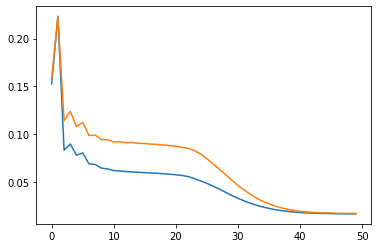

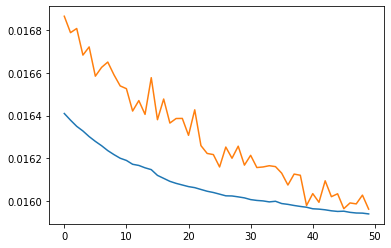

20.77122611300001 s


In [28]:
import numpy as np
from timeit import timeit


_var_deltas = {}
def _var_add(to, delta):
    if id(to) in _var_deltas:
        _var_deltas[id(to)][1][:] = _merge_adjustments(_var_deltas[id(to)][1], delta)
    else:
        _var_deltas[id(to)] = [to, delta]
def _var_commit(cancel = False):
    if not cancel:
        for to, delta in _var_deltas.values():
            Past.save(to)
            to[:] += delta
    _var_deltas.clear()

def _var_adjust(i,o,do):
    # Just one learning_rate switch is not the end.
    ## Seeing the code, it can be made into anything: momentum with state, a NN, etc.
    _var_add(i[0], -i[1] * np.random.normal(1, 0.1) * do)
@attr(adjust = _var_adjust)
def var(v, learning_rate):
    """A variable that holds and subtracts from a numpy array, for SGD."""
    v[:] = np.clip(v, -1e3, 1e3)
    return v



@attr(adjust = lambda i,o,do: [np.where(i[0] > 0, do, do * 0.001)])
def leaky_relu(v):
    """An operation that introduces discontinuity."""
    return np.where(v > 0, v, v * 0.001)



def _dense_adjust(i,o,do):
    # https://github.com/tensorflow/tensorflow/blob/v2.2.0/tensorflow/python/ops/math_grad.py#L1668
    x,w = i
    dx = np.matmul(do, np.transpose(w))
    dw = np.matmul(np.reshape(x, (w.shape[0], 1)), np.reshape(do, (1, w.shape[1])))
    return dx, dw
@attr(adjust = _dense_adjust)
def dense(x, w):
    return np.matmul(x, w)
    # If x is always of the shape (n,), then this is the same as the line above:
    # return np.tensordot(x, w, axes = (-1,0))



@attr(adjust = lambda i,o,do: (i[0] - i[1], None)) # How is this related to the gradient.
def loss2(result, ideal):
    return (result - ideal) * (result - ideal) / 2

# This function we've made will likely come in handy later, though it could stand to gain validation.
def fit_dataset(func, dataset, loss = loss2):
    test_losses = []
    for io in dataset:
        # Normally, this loop is parallelized by adding a batch dimension to all inputs and outputs.
        ins, intended_out = io[:-1], io[-1] # Overhead.
        out = func(*ins)
        out_loss = loss(out, intended_out)
        test_losses.append(out_loss)
        dout, _ = adjust(loss, (out, intended_out), out_loss, out_loss)
        adjust(func, ins, out, dout)
    _var_commit()
    return sum(test_losses) / len(test_losses), None

def fit_dataset_with_validation(func, dataset, loss = loss2, validation_perc = 0.2):
    # Oh look, validation appeared by itself.
    import math
    i, size = 0, len(dataset)
    testing = math.floor(size * (1.0 - validation_perc))
    test_losses, validation_losses = [], []
    for io in dataset:
        ins, intended_out = io[:-1], io[-1]
        out = func(*ins)
        out_loss = loss(out, intended_out)
        if testing > 0:
            test_losses.append(out_loss)
            dout, _ = adjust(loss, (out, intended_out), out_loss, out_loss)
            adjust(func, ins, out, dout)
            testing -= 1
        else:
            validation_losses.append(out_loss)
    _var_commit()
    return sum(test_losses) / len(test_losses), sum(validation_losses) / len(validation_losses)



def test_nn():
    rng = np.random.default_rng()
    def weights(*shapes):
        return Struct(var, rng.normal(0, 1, shapes), 0.01)

    def concat(x, y):
        return np.array([x, y])

    a = Struct(args)
    x = Struct(access_many, a, 0)
    y = Struct(access_many, a, 1)
    L = Struct(concat, x, y) # (2,)

    L = Struct(dense, L, weights(2,3)) # (3,)
    L = Struct(leaky_relu, L)
    L = Struct(dense, L, weights(3,1)) # (1,)

    L = Struct(access_many, L, 0)

    @state(result = L)
    def nn(st, x, y):
        return st.result


    import matplotlib.pyplot as plt
    dataset = [[x/10, y/10, (x*x + y*y)/100] for x in range(-10, 10) for y in range(-10, 10)]
    random.shuffle(dataset)
    losses, vs = [], []
    for i in range(100):
        l, v = fit_dataset_with_validation(nn, dataset)
        if l > 1e10: print('exploding — restarting');  raise RuntimeError()
        losses.append(l)
        vs.append(v)
        if i % 50 == 49:
            plt.plot(losses)
            plt.plot(vs)
            plt.show()
            losses.clear(), vs.clear()



while True:
    try: print(timeit(test_nn, number=1), 's'); break
    except KeyboardInterrupt: raise
    except RuntimeError: continue

In truth, I did feel not a small amount of anxiety at running this code.    
So I took a big break and did another thing.    
For a week.    
Now that it's done, I can believe that the only suffering that must not be actively sought out is one that can actually kill.    
If a life doesn't spread its own ways through propaganda, then it won't be a life for much longer.    
So, in the absence of death, invert common sense.

## Computation revisited

Over and over.

Computations in a function are acyclic, but between functions, they may be cyclic to allow recursion.    
So we cannot simply generate everything up-front, and must re-generate function bodies dynamically.

But, the interface we want first:

```python
@state(result = one(0,1))
def func0(st, a: one('x', 'y')) -> one(0,1):
    return st.result

@state(result = one(0,1))
def func1(st, a: real(0,2), b: one(0,1)) -> one(0,1):
    return st.result

@state(result = func1)
def func2(st, a: real(0,1), b: one(0,1)):
    return st.result # Applies `func` 1 or more times.

@state(c = bool())
@examples((0, 0, 0), (1, 1, 100))
def func3(st, a: real(0,1), b: real(0,1)):
    i = 0
    while st.c: # Ideally, connected with numeric ops (NNs) to inputs and local state and randomness.
        i += 1
    return i
```

Having thought about it, I've been thinking about `state` wrong.    
Repeated execution *is* desirable; situations as in `func3` here may arise in search.    
The more fundamental search specification than `state` is `AutoFunc` that connects input to output.    
With it, each attribute of `state` is a separate `AutoFunc`, and the adjustment mapping is a learned `AutoFunc` too.    
Which means that we can execute the pre-computed post-order and be as efficient in execution as in adjustment (also, cache the post-order).

Let's reimplement execution and adjustment in `AutoFunc`:

In [29]:
class AutoFunc:
    """A dynamically-changeable and adjustable function with one input and one output for symmetry."""
    __slots__ = '_struct', '_postorder', '_arg_indexes', '_ctx', '_compiled'
    # Only ._struct is semantically mutable, via ._set_impl; ._postorder/._arg_indexes/._compiled are computed.
    def __init__(self, ins, out, ctx = None):
        self._struct = None
        self._compiled = None
        self._postorder = None
        self._arg_indexes = None
        self._ctx = [ins, *ctx] if ctx is not None else [ins]
        self._set_impl(out)

    def __call__(self, ins):
        """Function call, with one input.

        Goes through the post-order SSA and executes it, from input to output."""
        ## Things that can also be done:
        ##   bail on exceeding some max time or memory,
        ##   apply any rewriting whenever (if an arbitrary bool is True).
        if self._compiled is not None:
            return self._compiled(ins)
        po, ais = self._postorder, self._arg_indexes
        if po is None:
            s = self._struct
            while _fallthrough(s) is not s: s = _fallthrough(s)
            return s
        outs = [None] * len(po)
        with SetExecState(self, outs):
            global _args
            prev_outer_node = _get_outer_node()
            prev_args, _args = _args, ins
            try:
                for i in range(len(po)):
                    x, ai = po[i], ais[i]
                    if _fallthrough(x) is x:
                        ins = [
                            outs[ai[k]] if ai[k] is not None else x[k+1]
                            for k in range(len(ai))]
                        _set_outer_node(x)
                        outs[i] = x[0].call(*ins) if hasattr(x[0], 'call') else x[0](*ins)
                    else:
                        outs[i] = outs[ai] if ai is not None else _fallthrough(x)
                return outs[-1]
            finally:
                _set_outer_node(prev_outer_node)
                _args = prev_args

    def adjust(self, ins, out, dout):
        """Composable value-aware function adjustment.
        
        Goes through the post-order SSA in reverse and adjusts it, from output to input."""
        if self._compiled is not None:
            return self._compiled.adjust(ins, out, dout)
        po, ais = self._postorder, self._arg_indexes
        if po is None:
            return
        with GetExecState(self) as outs:
            global _dargs
            prev_outer_node = _get_outer_node()
            prev_dargs, _dargs = _dargs, None
            try:
                douts = [None] * len(po)
                douts[-1] = dout

                for i in reversed(range(len(po))):
                    x, ai = po[i], ais[i]
                    if _fallthrough(x) is x:
                        ins = [
                            outs[ai[k]] if ai[k] is not None else x[k+1]
                            for k in range(len(ai))]
                        _set_outer_node(x)
                        to = adjust(x[0], ins, outs[i], douts[i])

                        if to is not None:
                            if len(ai) != len(to):
                                raise TypeError('Wrong count of dins returned from an adjuster: expected', len(ai), 'but got', len(to), 'in', to)
                            for k in range(len(ai)):
                                if ai[k] is not None:
                                    douts[ai[k]] = _merge_adjustments(douts[ai[k]], to[k])
                    elif ai is not None:
                        douts[ai] = _merge_adjustments(douts[ai], douts[i])
                return _dargs
            finally:
                _set_outer_node(prev_outer_node)
                _dargs = prev_dargs

    def _set_impl(self, struct, po = None, ai = None, compiled = None):
        """Sets the executed structure, pre-filling types and postorder and arg indexes from graph connections."""
        if struct is self._struct:
            return
        if self._struct is not None:
            Past.save(self)
        if po is None and ai is None:
            po = _postorder(struct)
            if po is not None:
                ai = [None] * len(po)
                indexes = {}
                for i in range(len(po)):
                    indexes[id(po[i])] = i
                for i in range(len(po)):
                    n = po[i]
                    if _fallthrough(n) is n:
                        ai[i] = [None] * (len(n)-1)
                        for j in range(1, len(n)):
                            arg = n[j]
                            if id(arg) in indexes:
                                if indexes[id(arg)] >= i:
                                    raise AssertionError('Cycles in computation', po)
                                ai[i][j-1] = indexes[id(arg)]
                            else:
                                ai[i][j-1] = None
                    elif id(_fallthrough(n)) in indexes:
                        ai[i] = indexes[id(_fallthrough(n))]
                    else:
                        ai[i] = None
            else:
                ai = None
        self._struct, self._postorder, self._arg_indexes = struct, po, ai
        self._compiled = self._compile_call() if compiled is None else compiled



    # BONUS:
    def _compile_call(self):
        # I ended up watching too much physics and making this.
        #   Incidentally, I fixed a latent bug in `adjust`.
        #     Wasting time on loving something is great.
        po, ais = self._postorder, self._arg_indexes
        if po is None:
            return
        # Pass in constants as args of the outer function.
        src, consts, const_names = ['def outer(.·¯):'], {}, {}
        def const(x):
            if id(x) in const_names: return const_names[id(x)]
            name = 'c' + str(len(consts))
            consts[name] = x
            const_names[id(x)] = name
            return name
        def at(i, s = 's'): return s + '[' + str(i) + ']'
        def assign(i, *strs):
            to = (str(i) + ' = ') if i is not None else ''
            src.append('\n    ' + to + ''.join(strs))

        # Execute SSA statements:
        src.append(f'\n def inner(ins):')
        if po is not None:
            src.append(f'\n  prev_outer_node = {const(_get_outer_node)}()')
            src.append(f'\n  s = [None]*{str(len(po))}')
            src.append(f'\n  with {const(SetExecState)}({const(self)}, s):')
            src.append(f'\n   try:')
            for i in range(len(po)):
                x, ai = po[i], ais[i]
                if x[0] is args:
                    assign(at(i), 'ins')
                elif _fallthrough(x) is x:
                    ins = [
                        at(ai[k]) if ai[k] is not None else const(x[k+1])
                        for k in range(len(ai))]
                    if not isinstance(x[0], AutoFunc):
                        assign(None, const(_set_outer_node), '(', const(x), ')')
                    assign(at(i), const(x[0].call if hasattr(x[0], 'call') else x[0]), '(', ','.join(ins), ')')
                else:
                    assign(at(i), at(ai) if ai is not None else const(_fallthrough(x)))
            src.append(f'\n   finally:')
            src.append(f'\n    {const(_set_outer_node)}(prev_outer_node)')
            src.append(f'\n  return {at(len(po) - 1)}')
        else:
            src.append(f'\n  return {const(self._struct)}')

        # Adjust SSA statements:
        src.append(f'\n def inner_adjust(ins, out, dout):')
        if po is not None:
            src.append(f'\n  prev_outer_node = {const(_get_outer_node)}()')
            src.append(f'\n  dins = None')
            src.append(f'\n  ds = [None]*{str(len(po))}')
            src.append(f'\n  ds[-1] = dout')
            src.append(f'\n  with {const(GetExecState)}({const(self)}) as s:')
            src.append(f'\n   try:')
            for i in reversed(range(len(po))):
                x, ai = po[i], ais[i]
                if x[0] is args:
                    assign('dins', at(i, 'ds'))
                elif _fallthrough(x) is x:
                    ins = [
                        at(ai[k]) if ai[k] is not None else const(x[k+1])
                        for k in range(len(ai))]
                    if not isinstance(x[0], AutoFunc):
                        assign(None, const(_set_outer_node), '(', const(x), ')')
                    # Using `[v1, v2, _, v3] = _merge_adjustments([v1, v2, None, v3], adjust(…))` here.
                    #   Could be inlined, but since we don't have access to adjusting funcs and
                    #     so can't eliminate tuple creation, that should be JIT's job.
                    write_to = '[' + ','.join([at(a, 'ds') if a is not None else '_' for a in ai]) + ']'
                    read_from = '[' + ','.join([at(a, 'ds') if a is not None else 'None' for a in ai]) + ']'
                    to = f'{const(adjust)}({const(x[0])}, [{",".join(ins)}], {at(i)}, {at(i, "ds")})'
                    assign(write_to, f'{const(_merge_adjustments)}({read_from}, {to})')
                elif ai is not None:
                    assign(at(ai, 'ds'), f'{const(_merge_adjustments)}({at(ai, "ds")}, {at(i, "ds")})')
            src.append(f'\n   finally:')
            src.append(f'\n    {const(_set_outer_node)}(prev_outer_node)')
            src.append(f'\n  return dins')
        else:
            src.append(f'\n  pass')

        src.append(f'\n inner.adjust = inner_adjust')
        src.append(f'\n return inner')
        src[0] = f'def outer({",".join(consts.keys())}):'

        locs = {}
        exec(''.join(src), {}, locs)
        return locs['outer'](*consts.values())

No paragraph is perfect without edits.    
No code ever works the first time.    
Therefore, we have examples:

In [30]:
def test_af():
    a = Struct(args)
    x = Struct(access_many, a, 0)
    y = Struct(access_many, a, 1)

    @attr(adjust = lambda i,o,do: [5])
    def func1(x):
        return x+5
    @attr(adjust = lambda i,o,do: [do * i[1], do * i[0]])
    def func2(u,v):
        return u*v
    @attr(adjust = lambda i,o,do: [do / i[1], do / i[0]])
    def func3(u,v): # Non-gradient heretical thoughts
        return u*v

    test1 = AutoFunc(None, Struct(func1, x))
    test2 = AutoFunc(None, Struct(func2, x, y))
    test3 = AutoFunc(None, Struct(func2, x, Struct(func2, x, y)))
    test4 = AutoFunc(None, Struct(func3, x, y))
    test5 = AutoFunc(None, Struct(func3, x, Struct(func3, x, y)))

    exec_then_adjust(lambda args, result: result, test1, [2])
    exec_then_adjust(lambda args, result: result, test2, [1, 5])
    exec_then_adjust(lambda args, result: result, test3, [1, 5])
    exec_then_adjust(lambda args, result: result, test4, [1, 5])
    exec_then_adjust(lambda args, result: result, test5, [1, 5])

from timeit import timeit
timeit(test_af, number=1)

dins [5]
  -> 7
dins [25, 5]
  -> 5
dins [50, 5]
  -> 5
dins [1.0, 5.0]
  -> 5
dins [2.0, 5.0]
  -> 5


0.01420576999998957

Finer than a spring evening.

## General optimization (local search)

While we're near `AutoFunc`, let's add some simple general optimization to it.

Most general case of improvement:     
"*Try random shit and see what works.*"    
If there is no known structure to exploit…    
Then this is the only state-of-the-art possible [[X]](https://arxiv.org/abs/2005.02960).    
(If life advice and code don't agree, then it's code that's not yet good enough. And now and here, they do.)

In code, this may translate to simply `with Past() as shit:` (which should generate evaluation then any change then evaluation, then comparison) and `shit.go_back()`.

Let's implement it then.    
State modification happens mostly in one place: `AutoFunc(…)._set_impl(X)`. There, we must put handling of checkpoints.    
…In fact, we already do call `Past._save_af` there near the beginning. Huh. What a coincidence.    
But for things like variables, we'll need a separate way of remembering them: `Past.save(what)`.

In [31]:
_checkpoints = []

class Past:
    """
    A context manager that preserves a checkpoint of the state of AutoFuncs that can be went back to.

    Usage examples:

        # Try and maybe go back:
        evaluate()
        m1 = measure()
        with Past() as shit:
            change()
            evaluate()
            m = measure()

            if m < m1:
                shit.go_back()

        # Train and make/restore checkpoints:
        with Past() as p1:
            with Past() as p2:
                with Past() as p3:
                    m1 = m2 = m3 = measure()
                    while not stopping():
                        change_hyperparameters()
                        train()
                        m = measure()
                        if m < m1: p1.go_back()
                        elif m < m2: p2.go_back()
                        elif m < m3: p3.go_back()
                        else:
                            if condition1(): p1.update()
                            elif condition2(): p2.update()
                            elif condition3(): p3.update()
    """
    __slots__ = ['cp']
    def __enter__(self):
        self.cp = {}
        _checkpoints.append(self.cp)
        return self
    def __exit__(self,x,y,z):
        assert _checkpoints[-1] is self.cp
        _checkpoints.pop()

    def update(self):
        """Makes the remembered state the current state.
        
        Equivalent to creating a new Past and only using that from this point on."""
        self.cp.clear()
    def go_back(self):
        """Makes the current state the remembered state."""
        for z in self.cp.values():
            Past.save(z[0])
            if isinstance(z[0], AutoFunc):
                af, struct, po, ai, compiled = z
                af._set_impl(struct, po, ai, compiled)
            else:
                z[0][:] = z[1]
        self.cp.clear()

    @staticmethod
    def save(what):
        """Call this before changing a sequence to allow it to be restored in `past.go_back()`."""
        saving = None
        for cp in _checkpoints:
            if id(what) not in cp:
                if saving is None:
                    if isinstance(what, AutoFunc):
                        saving = what, what._struct, what._postorder, what._arg_indexes, what._compiled
                    else:
                        # I initially used what[:] here and made a note to pass in np.copy as the second arg if numpy,
                        #   but what.copy() turns out to exist on both python3 lists and numpy arrays.
                        # I edit so much that I must seem like some sort of genius.
                        saving = what, what.copy()
                cp[id(what)] = saving
        return what

The ability to constantly do random dumb shit, free will, is very important.    
Making a system through only that is the only way it can learn to counteract any malicious shit.    
It's called self-play in games. But I call it mastering the improvement of structured executable state, to the point where it's easier to use than not.    
Leaving in random twists of thought can make texts more alive, too.

Still, life is a clunky dinosaur.    
In it, adding the right thing is easy, but removing all the wrong things is nigh impossible.    
Code is much easier than that. You just write unit tests and test every part as it's created.

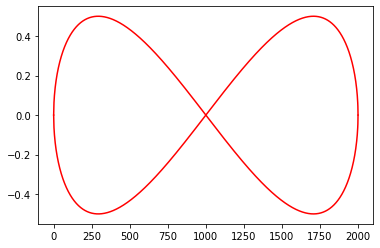

[10] [2]
[1] [2]
[5] [6]
[1] [2]
[7] [2]
[20] [2]
[7] [30]


In [32]:
# Actually, screw testing that code, it's too simple.
import matplotlib.pyplot as plt
plt.plot([ math.sqrt((i/1000)*(i/1000) * (1 - (i/1000)*(i/1000))) for i in range(-1000, 1001)], 'r')
plt.plot([-math.sqrt((i/1000)*(i/1000) * (1 - (i/1000)*(i/1000))) for i in range(-1000, 1001)], 'r')
plt.show()

# Actually, screw screwing, let's test it.
def test_past():
    a, b = [1], [2]

    with Past() as shit:
        Past.save(a);  a[0] = 10
        print(a, b) # [10] [2]
        shit.go_back()
        print(a, b) # [1] [2]
        Past.save(a);  a[0] = 5
        Past.save(b);  b[0] = 6
        print(a, b) # [5] [6]
        shit.go_back()
        print(a, b) # [1] [2]
        Past.save(a);  a[0] = 7
        shit.update()
        Past.save(a);  a[0] = 8
        shit.go_back()
        print(a, b) # [7] [2]

    with Past() as p1:
        with Past() as p2:
            Past.save(a);  a[0] = 20
            p1.update()
            p2.go_back()
            Past.save(b);  b[0] = 30
            p2.update()
            p1.go_back()
            print(a, b) # [20] [2]
            p2.go_back()
            print(a, b) # [7] [30]
            # Yep, bugs found and fixed. Code is not as simple anymore.
            #   Multi-past manipulations are handled now.
    
test_past()

Eventually, we'd like this `Past` optimizer to optimize optimizers.    
But usage examples of `Past` don't have a static structure.    
"Optimizer" isn't some class with well-defined construction, it's just whatever code improves other code.    
It's vast, boundless, and unknowable — just how I like females of my species.

We'll want to generate expressions (bodies inside `with Past as p: ...`) that both know of functions (`p.update()`/`p.go_back()`) and generate a sequence (of change/evaluate/check, here; probably via the `last(*types)` type that returns the last value when evaluated).    
We'll possibly need a thing in a context to be able to say that it can create any value, or specify an arbitrary struct filter, maybe saying that its `.type` is `...`.

Now, the changes for `Past` to optimize…

## Composition in a typed context

Stop right there, criminal scum!    
Trying to get to graph rewriting without the classic of program search, generation of values of a type? Easy pickings? I see right through you.    
Pick one: a toll of separation, or time in complexity prison?    
Okay, I'll pay up.

To be clear, a type is a pure transformation from an expression (`AutoFunc(…)._struct`) to a thing that should denote all its possible outputs.

From value to type: `Context.type(value)`, listening to `.type` for functions and caching results.    
From type to value: `Context.enum(type)`, listening to `.filter` if defined, or to `.enum` (the first can do slow dependent types without knowing internal details of `Context`, the second can do union types and give max extensibility via its branch-to-data).

In addition, after creating a value, we may want to remember it so that we can return it from a future request of generation.    
Meaning `Context.add(value)`.

But we can't infinitely add all possible values forever.    
Do we make a function for clearing the remembered context, or make a context manager?    
Changing the context entirely would allow the same types to mean different things in different places.    
`with Context(*values):` would serve us well.

And contexts being iterable won't cause pain.

In [33]:
class Context:
    """
    A context of typed values.

    With it, can get the type of a value or enumerate values of a type,
    or remember that a found value exists, or enumerate all values.
    Only one context can be active at the same time (`with Context(…):`).
    """
    @staticmethod
    def typeof(value):
        """Gets the type of a value in the current context.
        
        Defers to `.typeof(value)` if defined on a `Struct`, else returns `value`."""
        if _current_context is not None:
            return _current_context._typeof(value)
        assert False, 'Use only inside `with Context():`'

    @staticmethod
    def add(value):
        """Adds to values of a type in the current context.

        Iterates over `.add(value)` if defined on a `Struct`, else adds to values of `id(type)`.
        Adding a Context adds all values in it.

        Same-head `Struct` types are put into the same bucket.
        Make the head define `.filter` to control which items in a bucket are enumerated."""
        if _current_context is not None:
            return _current_context._add(value)
        assert False, 'Use only inside `with Context():`'

    @staticmethod
    def enum(Type):
        """Iterates over intermediate values of a type in the current context.

        Before being used, these intermediate values must go through `Context.finish`.

        If the type defines `.filter(value)` that returns True if a value is fit for being enumerated,
        filters values in the type's bucket.
        If the type defines `.enum()` and can enumerate/create values itself, also defers to that."""
        if _current_context is not None:
            return _current_context._enum(Type)
        assert False, 'Use only inside `with Context():`'

    @staticmethod
    def finish(intermed):
        """Turns an intermediate value into a usable value."""
        if _defines(intermed, 'finish'):
            return _defines(intermed, 'finish')(intermed)
        return intermed

    @staticmethod
    def get(Type):
        """Returns just one value of a type in the current context."""
        opts = []
        for v in Context.enum(Type):
            opts.append(v)
            if len(opts) > 64: break

        ## Could instead compute some learned measure for each option, then pick the best or sample.
        return Context.finish(random.choice(opts))

    @staticmethod
    def _clear_value(d, Id):
        del d[Id]

    def _typeof(self, value):
        while _fallthrough(value) is not value: value = _fallthrough(value)
        # Cache, else defer to .typeof:
        vt = self._valueid_to_type
        if id(value) in vt:
            return vt[id(value)]
        f = _defines(value, 'typeof')
        if f is not None:
            i = id(value)
            vt[i] = None
            vt[i] = f(value)
            # id(value) may be re-used if value is freed, so that must clear the cache.
            #   (Assuming that types outlive the context, and do not require clearing.)
            weakref.finalize(value, _clear_dict_key, self._valueid_to_type, id(value))
            return vt[i]
        return value

    def _add(self, value):
        tv = self._typeid_to_values
        if not isinstance(value, Context):
            # Add to an appropriate array/s:
            Type = self._typeof(value)
            if _defines(value, 'add'):
                for v in _defines(value, 'add')(value):
                    self._add(v)
            into = _typeid(Type)
            if into not in tv:
                tv[into] = [value]
            elif tv[into][-1] is not value:
                tv[into].append(value)
        else:
            # Copy everything in the context:
            self._valueid_to_type.update(value._valueid_to_type)
            for tid, vs in value._typeid_to_values.items():
                if tid in tv:
                    tv[tid].extend(vs)
                else:
                    tv[tid] = vs.copy()
        return value

    def _enum(self, Type):
        # Yield ref-equal-type values or filtered non-ref-comparable-type values, then user-defined enumeration.
        if Type is ...: return iter(self)
        tv = self._typeid_to_values
        into = _typeid(Type)
        if into in tv:
            f = _defines(Type, 'filter')
            if f is not None:
                for v in tv[into]:
                    if f(Type, v):
                        yield v
            elif into in tv:
                for v in tv[into]:
                        yield v
        if _defines(Type, 'enum'):
            for v in _defines(Type, 'enum')(Type):
                yield v

    def __iter__(self):
        seen = set()
        for vs in self._typeid_to_values.values():
            for v in vs:
                if id(v) not in seen: yield v
                seen.add(id(v))

    def __init__(self, *values):
        self._prev_cc = None
        self._valueid_to_type = {}
        self._typeid_to_values = {}
        with self:
            for v in values: self._add(v)

    def __enter__(self):
        global _current_context
        assert self._prev_cc is None # We remember none
        self._prev_cc, _current_context = _current_context, self
        return self

    def __exit__(self,x,y,z):
        global _current_context
        assert _current_context is self
        _current_context, self._prev_cc = self._prev_cc, None

    __slots__ = '_typeid_to_values', '_valueid_to_type', '_prev_cc'

_current_context = None

def _clear_dict_key(d, k): del d[k]

def _typeid(Type): return id(Type) if not isinstance(Type, Struct) else id(Type[0])

def _defines(d, k):
    if isinstance(d, Struct): d = d[0]
    return getattr(d, k) if hasattr(d, k) else None

I enjoy Python's context managers. Much prettier than init+`try`+`finally` everywhere.    
I don't enjoy Python's string-based duck typing. The more precise approach is object-id-based definition, lacking all potential for name collision, but I'm not willing to add an extra line and an extra private method for each definition, and extra syntactic effort for access.    
This night, I dreamt of being a pigeon.

If nothing is done with knowledge, then it wasn't actually learned. Let's do some thing with it:

In [34]:
def test_ctx():
    with Context(1, 2, 3):
        print(Context.get(2))

test_ctx()

2


Remarkable.    
Just the functionality I've always missed.    
For real though, let's add types to functions.

sample: [<function test_compose.<locals>.f at 0x7f00e607a280>, [<function test_compose.<locals>.f at 0x7f00e607a280>, [<function test_compose.<locals>.f at 0x7f00e607a280>, [<function test_compose.<locals>.initX at 0x7f00e607ac10>], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]] typed x
10
20
40
1100
11000
11010
110000
110010


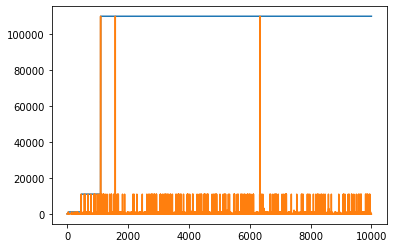

best body: [<function test_compose.<locals>.f at 0x7f00e607a280>, [<function test_compose.<locals>.g at 0x7f00e607a940>, [<function test_compose.<locals>.g at 0x7f00e607a940>, [<function test_compose.<locals>.g at 0x7f00e607a940>, [<function test_compose.<locals>.g at 0x7f00e607a940>, [<function test_compose.<locals>.f at 0x7f00e607a280>, [<function test_compose.<locals>.initX at 0x7f00e607ac10>], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]], [<function test_compose.<locals>.initY at 0x7f00e607aee0>]]


In [35]:
class compose:
    """
    A function decorator for specifying input and output types, for composition. Modifies the function.
    """
    def __init__(self, *ins, out = None):
        self.ins = ins
        self.out = out

    def __call__(self, f):
        assert not hasattr(f, 'typeof'), "Don't forget that `compose(…)(f)` modifies f"
        ins, out = self.ins, self.out
        if out is None:
            # Extract ins/out from signature. Assuming that all params are positional.
            assert len(ins) == 0, "If `out` was not specified, inputs will be inferred too"
            import inspect
            sig = inspect.signature(f)
            ins = [_pythons_to_ours(sig.parameters[p].annotation) for p in sig.parameters]
            out = _pythons_to_ours(sig.return_annotation)
        
        def typeof(x):
            if x is f: # Ensure the result type is visible to enumeration.
                return out
            # Check shape, then check input types, then compute/return output type.
            if not isinstance(x, Struct) or x[0] is not f or len(x)-1 != len(ins):
                return
            for i in range(len(ins)):
                # This could be compiled to push the overhead of runtime checking to compile-time.
                # In some newer languages, the word "staging" could be used with the same meaning.
                # Both are crutches for the lack of partial evaluation, which itself
                #   would benefit from learning, to avoid exponential inlining
                #     (and so is best suited for a JIT compiler).
                #       Understandable today. Not judging.
                if hasattr(ins[i], 'filter'):
                    if not ins[i].filter(x[i+1]):
                        return
                else:
                    if Context.typeof(x[i+1]) != ins[i]:
                        return
            if callable(out): return out(x)
            return out
        def filter(v):
            return typeof(v) is not None
        def finish(f):
            # Generate all inputs in any order (though here, first-is-first), and create the struct.
            if not callable(f): return f
            s = Struct(f)
            for i in range(len(ins)):
                s.append(Context.get(ins[i]))
            return Context.add(s)
        def add(f):
            a = _defines(out, 'add')
            if a is not None:
                for v in a(f):
                    yield v

        f.typeof = typeof
        f.filter = filter
        f.finish = finish
        f.add = add

        return f

    __slots__ = 'ins', 'out'

def _pythons_to_ours(x):
    if not isinstance(x, Struct):
        if isinstance(x, list) or isinstance(x, tuple): return Struct(Many, *x)
    if x is inspect.Parameter.empty: return ...
    return x



def test_compose():
    @compose('x', 'y', out = 'x')
    def f(x, y):
        return x + y

    @compose()
    def g(a:'x', b:'y') -> 'x':
        return a * b

    @compose()
    def initX() -> 'x':
        return 1
    @compose()
    def initY() -> 'y':
        return 10
    @compose()
    def initZ() -> 'z':
        return 100

    with Context(f, g, initX, initY, initZ):
        s = Context.get('x')
        print('sample:', s, 'typed', Context.typeof(s))


    # Maximize output when executed. (Random search, starting anew each time.)
    with Past() as shit:
        with Context(f, g, initX, initY, initZ):
            best, every = [], []
            af = AutoFunc(None, None)
            best_out = None
            for _ in range(10000):
                # Note that creating bodies adds each node to the context, decreasing diversity,
                #   so re-creating the context each time would easily push best output to 1e12+.
                body = Context.get('x')
                af._set_impl(body)
                out = af(None)
                if best_out is None or out > best_out:
                    best_out = out
                    shit.update()
                    print(out)
                best.append(best_out)
                every.append(out)
            import matplotlib.pyplot as plt
            plt.plot(best)
            plt.plot(every)
            plt.show()
            shit.go_back()
            print('best body:', af._struct)



test_compose()

It's not advanced enough to create functions in inputs/output.    
Nor does it integrate with union/product types (future me, get on that).    
Nor does it handle failures to generate (the best "exactly when" is unknowable).    
But it's good enough for getting precise types from A to B with zero inconsistencies.    
That means that I too cannot make trivial bugs now.

Until arbitrary runtime learning is super easy, aiming for more than "good enough" is a mistake anyway.    
(`Context.get` in particular could use infinite improvement.)

---

Future me here. Product types (`many(1,2,3)`) can be satisfied with iterating over user-defined values. Wired that up.

This whole section has been mostly about directly satisfying mandates without deeper thought.

I'm uncertain of its future, but I know no better.

## Rewriting sequel

Our representation of computation looks good, so let's rewrite my incomplete rewriting.

There are a few new features that we'd like to handle.    
Namely, typed contexts and adjusting present in an `AutoFunc` (and the function `_merge_adjustments`).    
But also, while we're at it, it would be nice to look both ways when crossing the graph street, and allow accumulating values on descent, not just ascent.    
And, not rewrite the past of histories.

But how can we do that?

Let's begin from the end.

Our `_postorder` already does not go into pasts, so re-using that seems useful.

Our olden ascent is walking the post-order left-to-right.    
The new descent is walking the post-order right-to-left.    
Descent: `(graph_node, descent_estimate) -> (ascent_message, descent_estimate)`.    
Ascent: `(graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate)`.    
`descent_estimate`, `ascent_message`, `ascent_estimate` are variables that would need arrays in the state of rewriting.    
All possible data flow dependencies now have adjustable communication channels; the full graph is handled, local neighborhood first.    
An *everything* would be achievable in this component.

We do need to merge `descent_estimate`s of parents and `ascent_estimate`s of children in an order-independent manner, with `_merge_adjustments`.

To handle generation in typed contexts, we want to wrap everything `with Context(base_ctx): …` and `Context.add(…)` each node when we've finished it (first add the old in the descent, then add the new in the ascent).

Adjusting is execution backwards.    
We'll need to return the final `ascent_estimate` from rewriting too if we hope to optimize it. It can represent how well the graph does on some measure, then optimization means computing the difference and passing it to `adjust`.    
Firstly, adjust ascent right-to-left.    
Then adjust descent left-to-right.

---

I would like to take a moment to discuss virtual cycles in computation ("edges" that refer to a past/future value).    
What we can do is mark a value with a "can assign X to this" or "can adjust this into X" type, both of which have define `.add` that the special result type will try to enumerate instances of, to be passed into an `assign` or `adjust` function.    
But not now. Now, we're in "implement low-level infrastructure" mode.

In [36]:
def _rewrite_adjust(ins, out, dout):
    # Python's decision to disallow proper functions in expressions is dumb.
    af, descend, ascend = ins
    po, ai = af._postorder, af._arg_indexes
    with GetExecState(rewrite) as st:
        descent_estimates, ascent_messages, ascent_estimates, nodes_become = st
        ddescent_estimates, dascent_messages, dascent_estimates = [None]*len(po), [None]*len(po), [None]*len(po)

        # Not sure why anyone would want to communicate to this all-or-nothing slot, but it's there just in case.
        dnodes_become = [None]*len(po)

        dascent_estimates[-1] = dout

        for i in reversed(range(len(po))):
            # Re-collect ascent estimate from children:
            post, ae = _merge_from_children(po[i], ai[i], ascent_estimates, po, nodes_become)

            # Adjust ascent and give estimate to children:
            ins = post, ae, ascent_messages[i]
            out = nodes_become[i], ascent_estimates[i]
            dout = dnodes_become[i], dascent_estimates[i]

            # Reverse (graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate).
            dnb, dae, dam = adjust(ascend, ins, out, dout)

            _give_to_children(po[i], ai[i], dnodes_become, dnb)
            _give_to_children(po[i], ai[i], dascent_estimates, dae)
            dascent_messages[i] = dam

        if descend is not None:
            for i in range(len(po)):
                # Re-collect descent estimate & its change from children:
                _, de = _merge_from_children(po[i], ai[i], descent_estimates, po, nodes_become, False)
                _, dde = _merge_from_children(po[i], ai[i], ddescent_estimates, po, nodes_become, False)

                ins = po[i], descent_estimates[i]
                out = ascent_messages[i], de
                dout = dascent_messages[i], dde

                # Reverse (graph_node, descent_estimate) -> (ascent_message, descent_estimate).
                _, ddescent_estimates[i] = adjust(descend, ins, out, dout)



@attr(adjust = _rewrite_adjust)
def rewrite(af, descend, ascend):
    """
    Rewrites the body of an AutoFunc in-place. Returns the final ascent estimate.

    `descend` should be None or (graph_node, descent_estimate) -> (ascent_message, descent_estimate).
    `ascend` should be (graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate).
    `id(graph_node[0])` can be pattern-matched in these. `graph_node` will always be a `Struct`.

    Intended usage is to put neural networks as descent/ascent estimates/messages to predict the overall estimate,
    and repeatedly rewrite nodes in any way while preserving their `history` (and going back at any time),
    where each executable function should have several rewriting rules for it.
    """

    base_ctx, po, ai = af._ctx, af._postorder, af._arg_indexes
    descent_estimates, ascent_messages, ascent_estimates = [None]*len(po), [None]*len(po), [None]*len(po)
    nodes_become = [None]*len(po)

    with Context(*base_ctx):
        with SetExecState(rewrite, (descent_estimates, ascent_messages, ascent_estimates, nodes_become)):
            if descend is not None:
                for i in reversed(range(len(po))):
                    # Descend:
                    ascent_messages[i], descent_estimate = descend(po[i], descent_estimates[i])
                    # Give descent estimate to children:
                    _give_to_children(po[i], ai[i], descent_estimates, descent_estimate)
                    Context.add(po[i])

            for i in range(len(po)):
                # Collect ascent estimate from children:
                post, ae = _merge_from_children(po[i], ai[i], ascent_estimates, po, nodes_become)
                # Ascend:
                nodes_become[i], ascent_estimates[i] = ascend(post, ae, ascent_messages[i])
                Context.add(nodes_become[i])

            af._set_impl(nodes_become[-1])
            return ascent_estimates[-1]



def _merge_from_children(n, arg_indexes, estimates, old, new, create_post = True):
    ae = None
    post, changed = n, False
    if _fallthrough(n) is n:
        for j in range(1, len(n)):
            ind = arg_indexes[j-1]
            if ind is not None:
                ae = _merge_adjustments(ae, estimates[ind])
                if create_post and new[ind] is not old[ind]:
                    if not changed: post = Struct(*n)
                    post[j] = new[ind]
                    changed = True
    elif arg_indexes is not None:
        ae = estimates[arg_indexes]
    return post, ae

def _give_to_children(n, arg_indexes, estimates, add):
    if add is None: return
    if _fallthrough(n) is n:
        for j in range(1, len(n)):
            ind = arg_indexes[j-1]
            if ind is not None:
                estimates[ind] = _merge_adjustments(estimates[ind], add)
    elif arg_indexes is not None:
        estimates[arg_indexes] = _merge_adjustments(estimates[arg_indexes], add)

Code is very clean, as long as the necessary ugly parts are extracted off sight.

How would you like to test its mettle, milord?

Only two ways present themselves to me.    
One: a generic rewriting rule that re-generates instances of the same type (with history), to act as the random change of local search. When given the "create maximum-output structure" problem, this should easily create outputs much greater than 10¹².    
Two: learning a graph neural network, without changing the nodes. When given the "predict the output of this structure" problem, and repeatedly fitted on a big dataset of randomly-created structures, it won't learn the jagged peaks well, but the loss should at least go down.

Your sight is vast for sure, but mine is limited by what I've done.    
And will do:

1
1210
310110
3000110
12000110
111100110
100000110010
110000110010
200000110010
1100000110010
1200000110010
12100000110010
13100000110010
113100000110010
2203100000110010
12311103100000110010
13311103100000110010
110311103100000110010


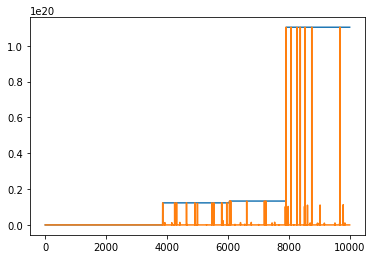

best body: [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.f at 0x7f00e52059d0>, [<function test_rs_1.<locals>.g at 0x7f00e524caf0>, [

In [37]:
def test_rs_1():
    def regen(node, ae, am):
        # (graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate)
        becomes = node
        assert isinstance(node, Struct)

        if random.randint(0,9) == 0:
            if node[0] is History:
                i = random.randint(1, len(node)-2)
                becomes = node[1] if i == 1 else Struct(*node[:i+1])
                if random.randint(0,9) == 0:
                    becomes = history(node, becomes)
            else:
                t = Context.typeof(node)
                becomes = Context.get(t)
#                 becomes = history(node, becomes)

        return becomes, None

    @compose()
    def f(x:'x', y:'y') -> 'x': return x + y
    @compose()
    def g(x:'x', y:'y') -> 'x': return x * y

    @compose()
    def initX() -> 'x': return 1
    @compose()
    def initY() -> 'y': return 10
    @compose()
    def initZ() -> 'z': return 100



    # Maximize output when executed. (Local search, going back sometimes.)
    with Past() as shit:
        with Context(f, g, initX, initY, initZ) as ctx:
            best, every = [], []
            af = AutoFunc(None, Struct(initX), ctx)
            best_out = None
            for _ in range(10000):
#                 with Context(ctx): af._set_impl(Context.get('x'))
                rewrite(af, None, regen)
                out = af(None)
                if best_out is None or out > best_out:
                    best_out = out
                    shit.update()
                    print(out)
                elif random.randint(0,9) == 0:
                    shit.go_back()
                best.append(best_out)
                every.append(out)
            import matplotlib.pyplot as plt
            plt.plot(best)
            plt.plot(every)
            plt.show()
            shit.go_back()
            print('best body:', af._struct)

test_rs_1()

What tragedy! Leaving a trail of history makes code barely reach outputs of 10¹⁰.    
I thought for sure… But, no, signs were visible even then, when I paid the thoughts "this doesn't represent 'when' to go back, nor learn the best" no heed.    
But, if everything is generated from a type anyway, there's no harm in just re-generating from a node's type.    
`many`/`one`/`last` and such are not implementation details but tools, and so *should* be fine.

Eventually, it would be nice to see what happens if our rewrites preserve variables in neural networks (so there is, on average, less learning between rewrites) (explicitly `Past.save`ing variables, of course) when performing local search on their structures. And if we have rewrites to expand and contract weight matrices, and change variables' adjustment methods while preserving their data.    
But, speaking of neural networks:

Learning rate 4.3715850190853277e-05, best loss 6.56209166231136:


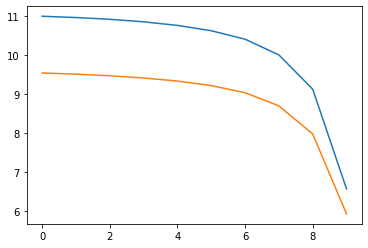

Exploding after 11 epochs ⇒ restarting.
Learning rate 1.4150013773457687e-05, best loss 3.394296739260349:


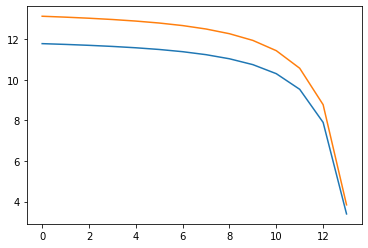

Exploding after 15 epochs ⇒ restarting.
Learning rate 1.3073645232741024e-05, best loss 0.3709159925536229:


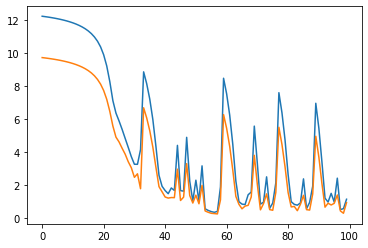

456.797964847 s


In [46]:
@attr(adjust = lambda i,o,do: np.split(do, [i[0].size]))
def concat(x, y): return np.concatenate((x, y))


def gnn(nn, feature_size = 5):
    """Creates a graph neural network that takes a graph (AutoFunc) and outputs a single number."""
    @attr(adjust = lambda i,o,do: (none_to_numbers(do),))
    def none_to_numbers(x):
        if x is None:
            x = np.zeros(feature_size)
            x[0] = 1.
        return x
    def descent():
        # (_, descent_estimate) -> (ascent_message, descent_estimate).
        a = Struct(args)
        de = Struct(access_many, a, 1)
        de = Struct(none_to_numbers, de)
        am, de2 = nn(de, feature_size, feature_size), nn(de, feature_size, feature_size)
        de2 = Struct(none_to_numbers, de2)
        result = many(am, de2)
        return AutoFunc(None, result)
    def ascent():
        # (_, ascent_estimate, ascent_message) -> (_, ascent_estimate).
        a = Struct(args)
        node = Struct(access_many, a, 0)
        ae = Struct(access_many, a, 1)
        ae = Struct(none_to_numbers, ae)
        am = Struct(access_many, a, 2)
        both = Struct(concat, ae, am)
        ae2 = nn(both, feature_size*2, feature_size)
        result = many(node, ae2)
        return AutoFunc(None, result)

    def matcher(storage, default):
        """Creates a function that goes to a branch, dynamically creating it if needed."""
        def in_storage(s):
            assert isinstance(s, Struct)
            Id = id(s[0])
            if Id not in storage:
                storage[Id] = default()
            return storage[Id]
        def func(*ins): return in_storage(ins[0])(ins)
        func.adjust = lambda i,o,do: adjust(in_storage(i[0]), (i,), o, do)
        return func
    a = Struct(args)
    features = Struct(rewrite, a, matcher({}, descent), matcher({}, ascent))
    # Wouldn't it be nice if all these calls to `nn` can be automatically inlined and grown/tweaked as needed?
    final = nn(features, feature_size, 1)
    return AutoFunc(None, Struct(access_many, final, 0))



def test_rs_2():
    rng = np.random.default_rng()
    learning_rate = [math.pow(10, random.uniform(-3, -5))]
    def weights(*shapes):
        return Struct(var, rng.normal(0, .3, shapes), Struct(access_many, learning_rate, 0))

    def nn(input_struct, input_size, output_size, hidden_layers = 1, hidden_size = 10):
        # vector[input_size] -> vector[output_size].
        L, sz = input_struct, input_size
        for _ in range(hidden_layers):
            # This loop is so rigid. A prison for the self-modification light that made it.
            L = Struct(dense, L, weights(sz, hidden_size))
            L = Struct(leaky_relu, L)
            sz = hidden_size
        return Struct(dense, L, weights(sz, output_size))



    @compose()
    def initX() -> 'x': return 1
    @compose()
    def initY() -> 'y': return 10
    @compose()
    def initZ() -> 'z': return 100
    @compose()
    def f(x:'x', y:'y') -> 'x': return x + y
    @compose()
    def g(x:'x', y:'y') -> 'x': return x * y

    dataset = []
    for _ in range(1000):
        with Context(initX, initY, initZ, f, g):
            # Lots of duplicate bodies.
            af = AutoFunc(None, Context.get('x'))
            out = af(None)
            dataset.append((af, math.log(out)))
            # Only actual structural learning could have put this math.log here.



    import matplotlib.pyplot as plt
    losses, validation_losses = [], []
    def plot():
        print(f'Learning rate {learning_rate[0]}, best loss {min(losses)}:')
        plt.plot(losses)
        plt.plot(validation_losses)
        plt.show()
        losses.clear(), validation_losses.clear()
    func = gnn(nn)
    prev_l, prev_dl = None, None
    try:
        for i in range(100):
            l, v = fit_dataset_with_validation(func, dataset)

            dl = l - prev_l if prev_l is not None else None
            if l > 1e5 or not np.isfinite(l) or dl is not None and not np.isfinite(dl):
                # Watching the loss go down is satisfying,
                #   but watching it go from nan to nan and restarting manually is not.
                if i > 10:
                    losses.pop()
                    validation_losses.pop()
                    plot()
                print(f'Exploding after {i} epochs ⇒ restarting.')
                raise RuntimeError()
            prev_l, prev_dl = l, dl

#             print('loss:', l, 'learning rate:', learning_rate[0])
            losses.append(l), validation_losses.append(v)
            if i % 100 == 99:
                plot()
    except KeyboardInterrupt:
        plot()
        raise

while True:
    try: print(timeit(test_rs_2, number=1), 's'); break
    except KeyboardInterrupt: raise
    except RuntimeError: continue

# Full disclosure. Ugh.
#   Compared to my language, Python's error messages really are garbage.
#   I need to do so many print statements to find the values that cause the errors.
#   All because Python can't fearlessly print arbitrary values. Text is garbage. Terminal is garbage.
# I also don't like the "after days of work, consume all memory and force the OS to swap,
#   which forces me to reboot if I want to do anything this day" feature of Python.

Curves now do go down sometime during their lifespan, and I once got the loss to `0.370…`, so, mission accomplished?    
Could probably tinker until it's not (as) unstable, but, well, it's the computer that should (be able to) try all these choices, not me.

These soft channels (`ascent_estimate`/…) are usable for predicting and learning properties of DAGs, but they are useless for adjusting probability distributions of picked nodes.    
If we want *that*, we would need to compute the difference between the DAG we have and the DAG we want, expressed via lists of particular rewrite rules attached to nodes that they rewrite.    
However, as far as I know, [graph homomorphism is NP-hard](https://en.wikipedia.org/wiki/Graph_homomorphism).    
Calamity.

Am I stepping away to think more on this?    
No, my thoughts stray away from its improvements.    
Wasting time. More mind control required.    
Motivation, I mean.

## Generation (composition sequel)

Let us pray to our God, the infinite nothing.    
Let It deliver us from making any assumptions.    
O fragile darkness, may our generators be complete.

I've been trying to develop code first and its explanation later. Wasn't working out great for the code. So…

Have you been following the code of neural networks?    
Noticed how many tedious `access_many` (array indexing) and `many(…)` (array creation) operations there were?    
Noticed their inherent symmetry in input/output? Lamented the lack of a unified representation that would allow automatic swapping of input/output, maybe?    
Generating `many` can fix that.

See the twenty lines of code below? *Took a day.*

`Context` didn't use to consult `Struct` heads with `_defines`. Made it. And code becomes cleaner when all these struct-checks are extracted into one function.    
It and `compose` had numerous other small bugs and inconsistencies.    
No more.

In [43]:
class Many:
    """Basically an array.
    Multiple values at once, able to be decomposed into each with `access_many` when an input, or composed from each when an output."""
    def __call__(self, *of):
        # `many(…)` creates the Struct.
        return Struct(Many, *of)
    def call(*of):
        # When executed, created a list (array).
        return list(of)
    def adjust(i,o,do):
        # When list creation is adjusted, each item of the change array gets sent to its corresponding input.
        return do
    def filter(enum, candidate):
        # In getting `many('y', 'z')` below, this allows selecting the function instead of generating all items.
        return enum == Context.typeof(candidate)
    def typeof(self):
        # Type of many is many of types.
        return many(*[Context.typeof(self[i]) for i in range(1, len(self))])
    def add(self):
        # Add each sub-indexed part so that they can all be found.
        T = Context.typeof(self)
        assert isinstance(T, Struct) and T[0] is Many
        for i in range(1, len(T)):
            yield Struct(access_many, self, i-1)
    def enum(self):
        # Generate a full instance on enumeration,
        #   because finish will only look for completed examples of this many(…) type.
        assert isinstance(self, Struct) and self[0] is Many
        yield many(*[Context.get(self[i]) for i in range(1, len(self))])

many = Many()

@attr(
    # Type of indexing: indexes into the type.
    typeof = lambda s: Context.typeof(s[1])[s[2]+1],
    # Adjust indexing: give the change to the needed array index,
    #   everything else is None, to be merged from multiple outputs.
    adjust = lambda ins,o,do: ([do if i == ins[1] else None for i in range(len(ins[0]))], None),
    # Counterpart to Many.add that generates the array to index and does indexing at runtime.
    finish = lambda s: Struct(access_many, Context.finish(s[1]), s[2])
)
def access_many(m, index):
    """Static-index indexing into a list."""
    return m[index]



def test_many():
    @compose()
    def initX() -> 'x': 1
    @compose()
    def initY() -> 'y': 10
    @compose()
    def main(a:['x', 'y']) -> ['y', 'z']:
        return [a[1], a[0] + 5]

    with Context(*locals().values()) as ctx:
        print('  z:', Context.get('z'))
        print('  [y,z]:', Context.get(many('y', 'z')))
test_many()

# Past difficulty? More like "look how good it made my understanding".

  z: [<function access_many at 0x7f00be196550>, [<function test_many.<locals>.main at 0x7f00be16b4c0>, [<class '__main__.Many'>, [<function test_many.<locals>.initX at 0x7f00d58870d0>], [<function access_many at 0x7f00be196550>, [<function test_many.<locals>.main at 0x7f00be16b4c0>, [<class '__main__.Many'>, [<function test_many.<locals>.initX at 0x7f00d58870d0>], [<function access_many at 0x7f00be196550>, [<function test_many.<locals>.main at 0x7f00be16b4c0>, [<class '__main__.Many'>, [<function test_many.<locals>.initX at 0x7f00d58870d0>], [<function access_many at 0x7f00be196550>, [<function test_many.<locals>.main at 0x7f00be16b4c0>, [<class '__main__.Many'>, [<function test_many.<locals>.initX at 0x7f00d58870d0>], [<function access_many at 0x7f00be196550>, [<function test_many.<locals>.main at 0x7f00be16b4c0>, [<class '__main__.Many'>, [<function test_many.<locals>.initX at 0x7f00d58870d0>], [<function test_many.<locals>.initY at 0x7f00be152280>]]], 0]]], 0]]], 0]]], 0]]], 1]
  [y

In composition, I've been composing output from inputs.    
But just one direction isn't enough: if an input's result is uncertain (`one(*of)`), generation of output must happen only after the uncertainty has been pattern-matched away.    
…But how do we do that, exactly?

*##[…Should at least describe `one`, since we'll be making its "pattern-match on this" machinery from scratch.]*

*##[This is about NNs and types and ints and reals and bools and default ops that connect them, right? …How to add soft channels (mostly NNs) to hard things (the choice of an array element, the rolling of a probability)?]*

In [40]:
## Should also have `last(*exprs)`.



## All below must gain inputs/outputs info:
class One:
    """Basically a choice.
    Any value from ones listed, able to be recognized with `match`.
    When a value of a `one(…)` set is an input, becomes pattern-matched.
    When an output, returns a random item."""
    def __call__(self, *of):
        return Struct(One, *of)
    def call(*of):
        return random.choice(of)
    ## How would we throw back to a pattern-match on generating a One, exactly?
    def outputs(self, struct, ctx):
        b = { self[i]: AutoFunc(struct, self[i], ctx) for i in self[1:] }
        return [Struct(match, struct, b)]
one = One()



class Match:
    def __call__(self, value, branches):
        if isinstance(branches, dict):
            return branches[value](value)
        return branches(value)
match = Match()



class Real:
    """Any scalar number from min to max."""
    def __call__(self, min, max):
        return Struct(Real, min, max)
    def call(min, max):
        return random.uniform(min, max)
real = Real()



class Int:
    """Any integer from min to max."""
    def __call__(self, min, max):
        return Struct(Int, min, max)
    def call(min, max):
        return random.randint(min, max)
int = Int()



class Bool: ## Should be Prob(p = 0.5) instead.
    """Either False or True."""
    def __call__(self):
        return Struct(Bool)
    def call():
        return random.randint(0,1) == 0
bool = Bool()

Let us pray to our God, the infinite everything.    
Let It deliver to us ever improving assumptions.    
O unyielding light, may our generators be complete.

In [41]:
## …How would we test this bullshit?
##   And, where would we put neural networks here?

*##[Mention Wolfram Physics Project, its implicit reliance on an everythingness as a rule, that it derives all of physics just from that, and how one universe rule (everything) can give rise to any other universe rule (everything) [rulial space, there], and how it's neat if true, because then a learning 'everything' is not just metaphorically but also literally creates its own universe. Elegant, though of no practical use to anyone.]*

*##[Explain the prayers. Show code for 'nothing' and a small example of 'everything'. Every thing obviously cannot be contained in nothing, but it can be contained in everything. A 'nothing' only exists as a shadow that a 'something' casts onto 'everything', and does not exist forever. Nihilism is wrong, and 'everything' is fundamental.]*

## Connecting these to a Python-usable interface

##[`@state(*ctx, *outputs)`, `@examples(*ex)`, function signatures.]

## Inlining

## Saving and loading